# Presentation Notebook:

### Notebook to summarize everything covered in previous notebooks

- Introduction: Project Background (Dataset & Objective)
- Python Imports
- Preliminary Analysis (NAs, Imbalanced?, Metadata)
- Variable Analysis (Boxplots)
- Feature Engineering for each row: (mean, std, rounding, ect.)
- Scaling each variable: (StandardScaler, Min_Max, Normalizer)
- Under/Oversampling: (RandomUndersample, SMOTE, SMOTETomek)
- Algorithms pros/cons of each: (Logistic_Regression, KNN, Random_Forest, SVM, LightGBM)
- ROC/PR Curves
- Best Algorithm and Final Results

# Customer Transaction Prediction

![title](../../Images/santander_logo.png)

<hr>

# Introduction: Project Background

### This project is based on a Machine Learning Competition on Kaggle.com

https://www.kaggle.com/c/santander-customer-transaction-prediction

### If we were to open up train.csv in Excel:
- It would take about a minute to even open...
- and it would look like this:

![title](../../Images/Excel.png)

<hr>

# Python Imports:

In [1]:
# OS and Data Library Imports
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
import lightgbm as lgb


warnings.filterwarnings("ignore")
sns.set(style="darkgrid", font_scale=2)

<hr>

# Preliminary Analysis:

### What do these Datasets look like? Let's find out using a Pandas Dataframe

#### Train Data

In [2]:
# Import train data
train_csv_path = os.path.join("..","..","data","train.csv")
train_data = pd.read_csv(train_csv_path)
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
print("Dataset Shape\nRows:{0}\nColumns:{1}".format(train_data.shape[0],train_data.shape[1]))

Dataset Shape
Rows:200000
Columns:202


#### Test Data

In [4]:
# import test data
test_csv_path = os.path.join("..","..","data","test.csv")
test_data = pd.read_csv(test_csv_path)
test_data.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [5]:
print("Dataset Shape\nRows:{0}\nColumns:{1}".format(test_data.shape[0],test_data.shape[1]))

Dataset Shape
Rows:200000
Columns:201


#### Sample_Submission

In [6]:
# import sample_submission data
sample_submission_csv_path = os.path.join("..","..","data","sample_submission.csv")
sample_submission_data = pd.read_csv(sample_submission_csv_path)
sample_submission_data.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [7]:
print("Dataset Shape\nRows:{0}\nColumns:{1}".format(sample_submission_data.shape[0],sample_submission_data.shape[1]))

Dataset Shape
Rows:200000
Columns:2


### Observations:
- There are 200,000 Rows of training data and testing data
- There are 200 Variables of unknown significance.

### Is there any missing data? (aka: Is any data labeled NA?)

In [8]:
# Check for null values
print(f"Missing values in the Training Dataset: {train_data.isnull().values.any()}")
print(f"Missing values in the Testing Dataset: {train_data.isnull().values.any()}")

Missing values in the Training Dataset: False
Missing values in the Testing Dataset: False


### Is the dataset balanced? (Are there more 0's than 1's)

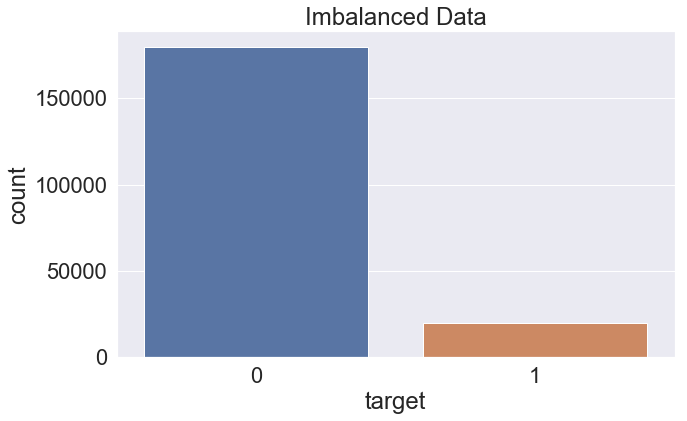

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="target", data=train_data, ax=ax)
ax.set_title("Imbalanced Data")
plt.show()

In [10]:
target_df = pd.DataFrame(train_data.target.value_counts())
target_df["Percentage"] = target_df["target"]/train_data.shape[0]
target_df["Percentage"] = target_df["Percentage"].map("{:,.2%}".format)
target_df

,target,Percentage
0,179902,89.95%
1,20098,10.05%


### Observations:
- ~90% of the training data has a target of 0.
- This could mean maybe we are trying to calculate Fraudulant Customer Transactions? Not sure

### What does the metadata look like?

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [12]:
print(f"Datatype of target: {train_data.target.dtype}")
print(f"Datatype of variables: {train_data.var_0.dtype}")

Datatype of target: int64
Datatype of variables: float64


### Observations:
- 200 columns of variables are floating point numbers
- They have a maximum of 4 decimal places
- Consists of both positive and negative numbers

<hr>

# Too Early Machine Learning Model:

### First we need to seperate the TARGET values from the FEATURES on the TRAIN DATA ONLY.

In [13]:
# Split to X and y
X = train_data.drop(columns=["ID_code","target"])
y = train_data.target

### Next we need to train_test_split the training data. WHY?
- We want a supervised machine learning model (meaning we want to know the correct answers to judge if it is indeed a good model)
- We can split the data into a train and test set. We'll use 70% of the data for training our model, and 30% of the data for testing our model accuracy.

In [14]:
# Split X and y into Train Data and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (140000, 200)
Test shape: (60000, 200)


### Finally lets plug in a simple LogisticRegression model and see what happens:

In [15]:
%%time
# LogisticRegression print classification report

# Model Creation with automatic inputs
logmodel = LogisticRegression()

# fit the model to training data
logmodel.fit(X_train, y_train)

# Predict target values
predictions = logmodel.predict(X_test)

# Print the score of the fitted model
print(logmodel.score(X_test, y_test))
print()
print(classification_report(y_test, predictions))

0.9137166666666666

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     54039
           1       0.66      0.27      0.38      5961

   micro avg       0.91      0.91      0.91     60000
   macro avg       0.79      0.63      0.67     60000
weighted avg       0.90      0.91      0.90     60000

Wall time: 2min 35s


### 91.3%! What Exactly happened here?

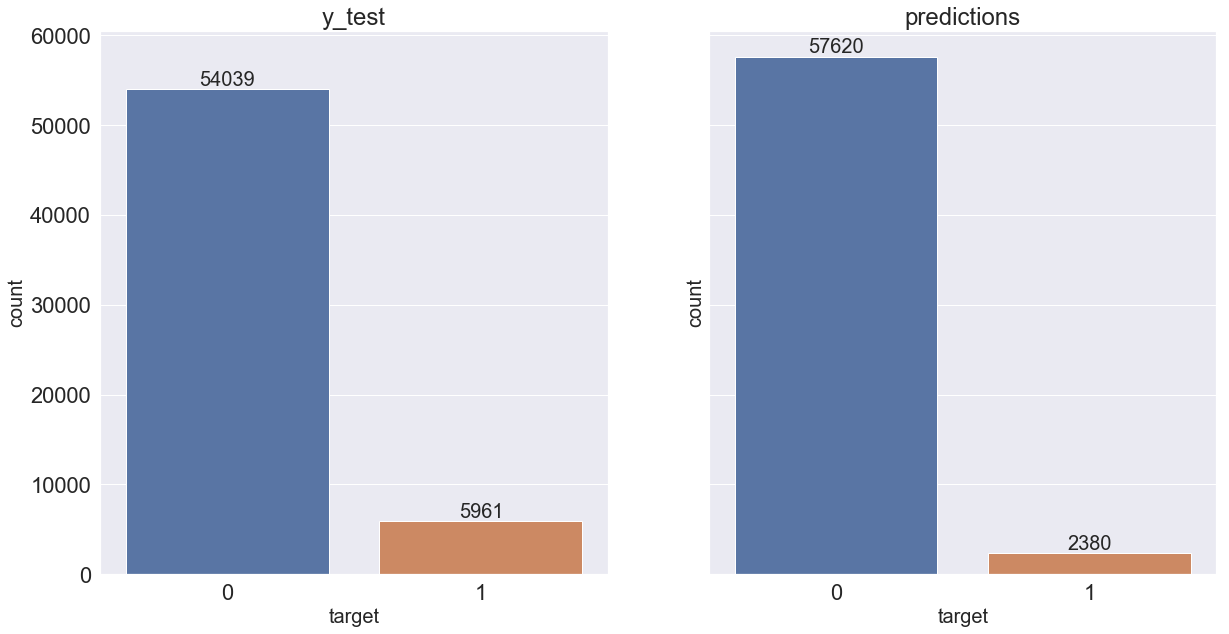

In [16]:
# Create a Count of 0's and 1's for both y_test and predictions
sns.set_style("darkgrid")
sns.set(font_scale = 2)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(20,10))
sns.countplot(x=y_test, ax=ax[0])
sns.countplot(x=predictions, ax=ax[1])
ax[0].set_title("y_test")
ax[1].set_title("predictions")

# Annotate the height above the plot
for a in ax:
    a.set_xlabel("target", fontsize=20)
    a.set_ylabel("count", fontsize=20)
    for p in a.patches:
        height = p.get_height()
        a.text(p.get_x()+p.get_width()/2., height + 400, height, ha="center", fontsize=20)

plt.show()

### Observations:
- Only 3.8% of the predictions guessed 1. y_test shows 10.2% to be 1
- Algorithm cleverly decided to guess 0 most of the time
- 0 Recall is very high, but 1 recall is dangerously low


<hr>

# Feature Analysis:

## Are there any correlations in this dataset?

In [17]:
# Define correlation dataframe
train_corr = train_data.iloc[:,2:].corr()
correlations = train_corr.abs().unstack().sort_values().reset_index()
correlations = correlations[correlations["level_0"] != correlations["level_1"]].rename(columns={0:"correlation_ratio"})
print("Highest Correlations")
print(correlations.sort_values(by="correlation_ratio", ascending=False).head(5))
print()
print("Lowest Correlations")
print(correlations.head(5))

Highest Correlations
       level_0  level_1  correlation_ratio
39799  var_139   var_26           0.009844
39798   var_26  var_139           0.009844
39797  var_148   var_53           0.009788
39796   var_53  var_148           0.009788
39795  var_165   var_81           0.009714

Lowest Correlations
   level_0  level_1  correlation_ratio
0   var_75  var_191       2.703975e-08
1  var_191   var_75       2.703975e-08
2  var_173    var_6       5.942735e-08
3    var_6  var_173       5.942735e-08
4  var_126  var_109       1.313947e-07


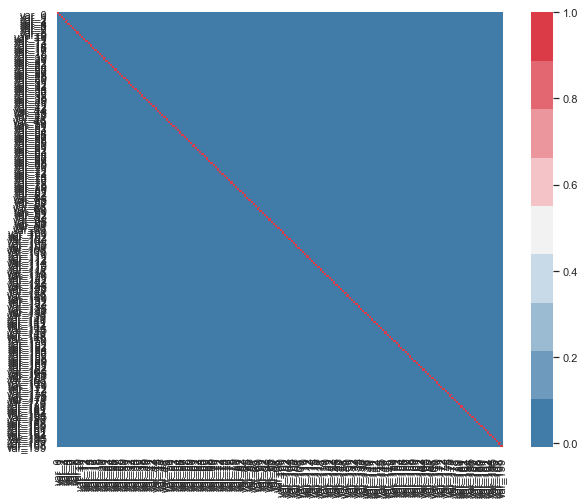

In [18]:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(
    train_corr,
    xticklabels=train_corr.columns,
    yticklabels=train_corr.columns,
    cmap=sns.diverging_palette(240, 10, n=9)
)
plt.show()

### Observations:
- We can infer little to no correlations among variables. 
- Highest correlation is not even 1%.

## Statistical Analysis:

In [19]:
colzerototen= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].min() >=0) & (train_data.loc[:,c].max()< 10) ]
print(len(colzerototen), " - Number of Features that are positive and maximum is less than 10")
colzerototwenty= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].min() >=0) & (train_data.loc[:,c].max() >= 10) & (train_data.loc[:,c].max() < 20)  ]
print(len(colzerototwenty), " - Number of Features that are positive and maximum range between 10 and 20")
colzeroandtwentyplus= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].min() >=0) & (train_data.loc[:,c].max() >= 20)]
print(len(colzeroandtwentyplus), " - Number of Features that are positive and maximum is above 20")
colzerominus= [c for c in train_data.iloc[:,2:].columns if train_data.loc[:,c].max() <0 ]
print(len(colzerominus), " - Number of Features that are all negative")
colplustenminusten= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() <= 10) & (train_data.loc[:,c].min() >=-10 )& (train_data.loc[:,c].min()< 0 )]
print(len(colplustenminusten), " - Number of Features that are between 10 and -10")
colplustwentyminusten= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() <= 20)& (train_data.loc[:,c].max() > 10) & (train_data.loc[:,c].min() >=-10 ) & (train_data.loc[:,c].min() < 0 )]
print(len(colplustwentyminusten), " - Number of Features that have a maximum between 10 and 20, and a minimum between -10 and 0")
colplustwentyminustwenty= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() <= 20) &  (train_data.loc[:,c].min() < -10 ) & (train_data.loc[:,c].min() >= -20 )]
print(len(colplustwentyminustwenty), " - Number of Features that have a maximum less than 20 and a minimum between -20 and -10")
colplustwentyminustwentyless= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() <= 20)& (train_data.loc[:,c].min() < -20 )]
print(len(colplustwentyminustwentyless), " - Number of Features that have a maximum less than 20 and a minimum less than -20")
colplustwentymoreminusten= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() >20)& (train_data.loc[:,c].min()< 0 ) & (train_data.loc[:,c].min()>= -10 )]
print(len(colplustwentymoreminusten), " - Number of Features that have a maximum more than 20 and a minimum more than -10")
colplustwentymoreminustwenty= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() >20)& (train_data.loc[:,c].min()< -10 ) & (train_data.loc[:,c].min()>= -20 )]
print(len(colplustwentymoreminustwenty), " - Number of Features that have a maximum more than 20 and a minimum between -20 and -10")
colplustwentymoreminustwentymore= [c for c in train_data.iloc[:,2:].columns if (train_data.loc[:,c].max() >20)& (train_data.loc[:,c].min()< -20 )]
print(len(colplustwentymoreminustwentymore), " - Number of Features that have a maximum more than 20 and a minimum less than -20")

16  - Number of Features that are positive and maximum is less than 10
31  - Number of Features that are positive and maximum range between 10 and 20
22  - Number of Features that are positive and maximum is above 20
0  - Number of Features that are all negative
14  - Number of Features that are between 10 and -10
17  - Number of Features that have a maximum between 10 and 20, and a minimum between -10 and 0
15  - Number of Features that have a maximum less than 20 and a minimum between -20 and -10
16  - Number of Features that have a maximum less than 20 and a minimum less than -20
28  - Number of Features that have a maximum more than 20 and a minimum more than -10
17  - Number of Features that have a maximum more than 20 and a minimum between -20 and -10
24  - Number of Features that have a maximum more than 20 and a minimum less than -20


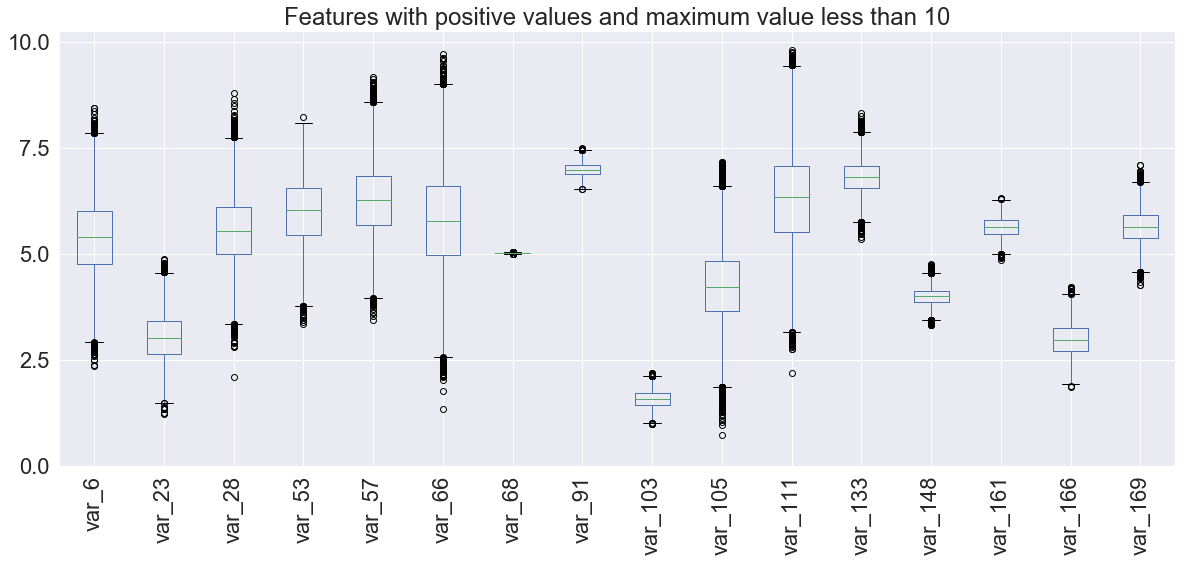

In [20]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setpositive=train_data.loc[:,colzerototen].boxplot(rot=90)
setpositive=setpositive.set(
    yticks=[0,2.5,5,7.5,10],
    title="Features with positive values and maximum value less than 10"
)

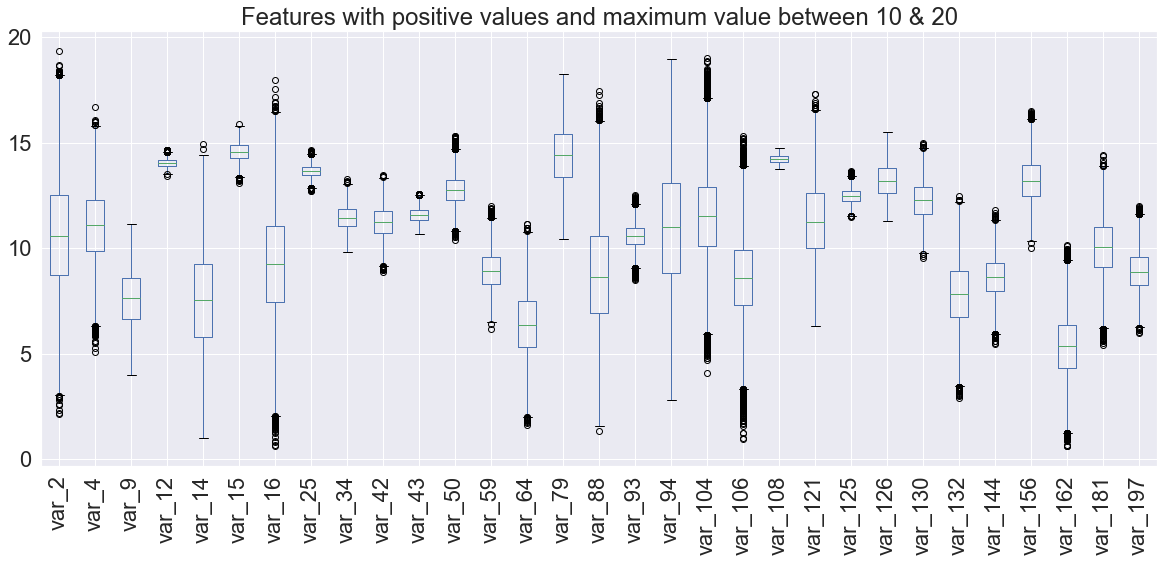

In [21]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setpositive20=train_data.loc[:,colzerototwenty].boxplot(rot=90)
setpositive20=setpositive20.set(
    yticks=[0,5,10,15,20],
    title="Features with positive values and maximum value between 10 & 20"
)

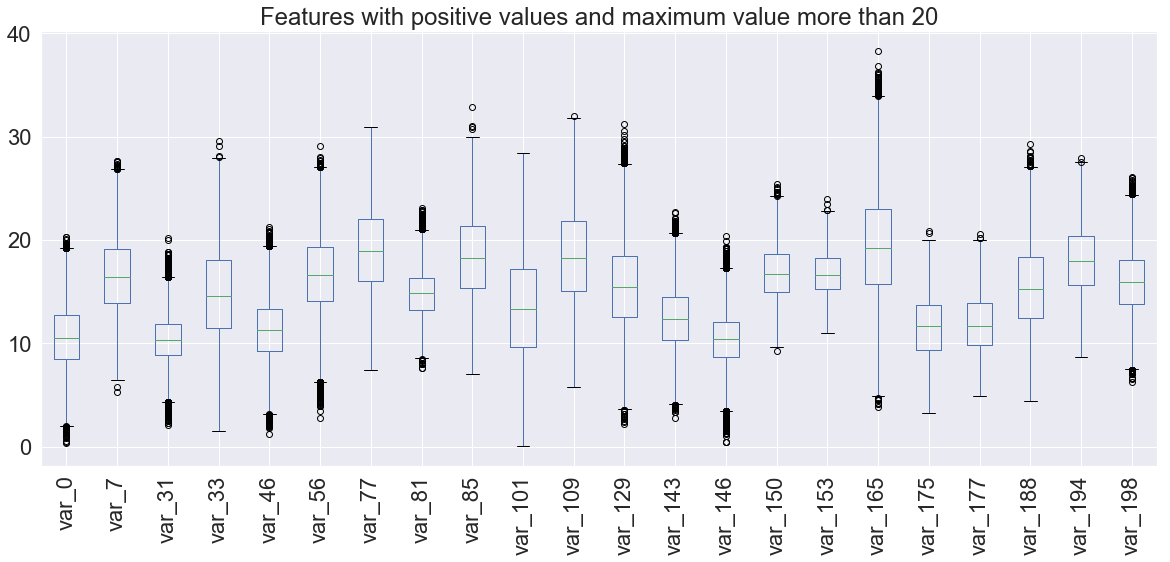

In [22]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setpositive20plus=train_data.loc[:,colzeroandtwentyplus].boxplot(rot=90)
setpositive20plus=setpositive20plus.set(
    yticks=[0,10,20,30,40],
    title="Features with positive values and maximum value more than 20"
)

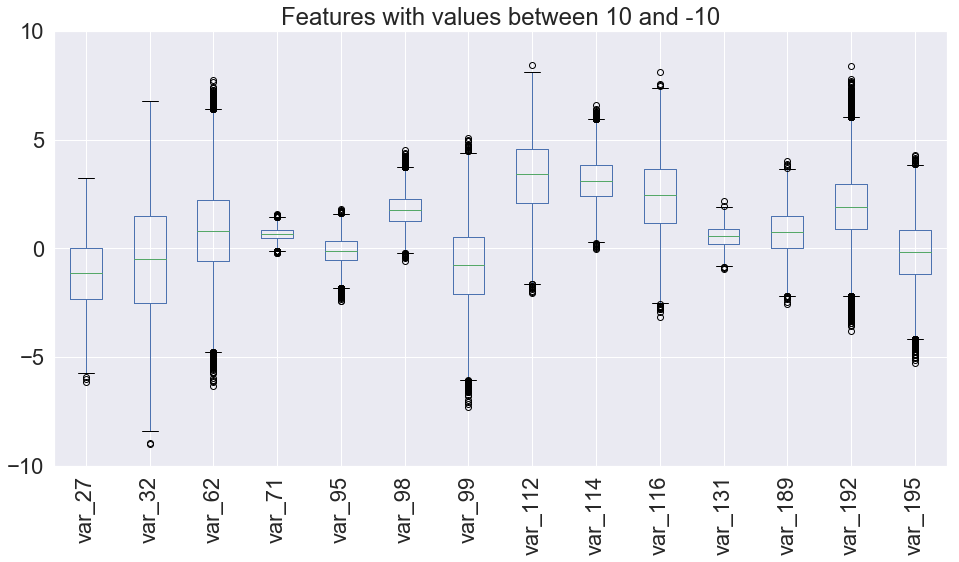

In [23]:
sns.set(rc={'figure.figsize':(16,8)}, font_scale=2)
setplustenminusten = train_data.loc[:,colplustenminusten].boxplot(rot=90)
setplustenminusten = setplustenminusten.set(
    yticks=[-10,-5,0,5,10],
    title="Features with values between 10 and -10"
)

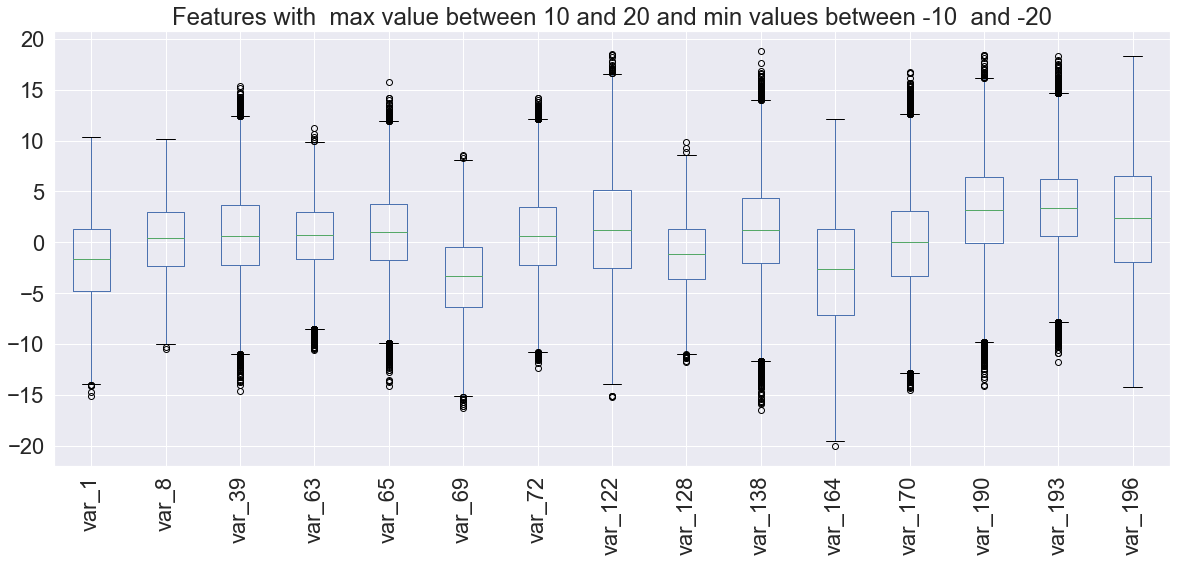

In [24]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setplustwentyminustwenty=train_data.loc[:,colplustwentyminustwenty].boxplot(rot=90)
setplustwentyminustwenty=setplustwentyminustwenty.set(
    yticks=[-20,-15,-10,-5,0,5,10,15,20],
    title="Features with  max value between 10 and 20 and min values between -10  and -20"
)

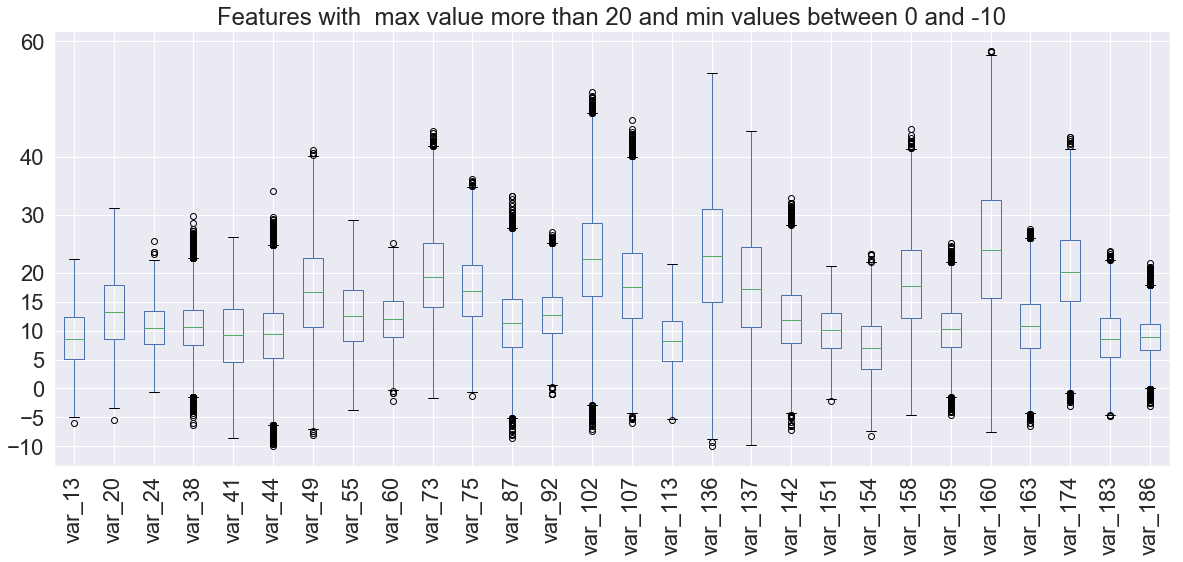

In [25]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setplustwentymoreminusten=train_data.loc[:,colplustwentymoreminusten].boxplot(rot=90)
setplustwentymoreminusten=setplustwentymoreminusten.set(
    yticks=[-10,-5,0,5,10,15,20,30,40,60],
    title="Features with  max value more than 20 and min values between 0 and -10"
)

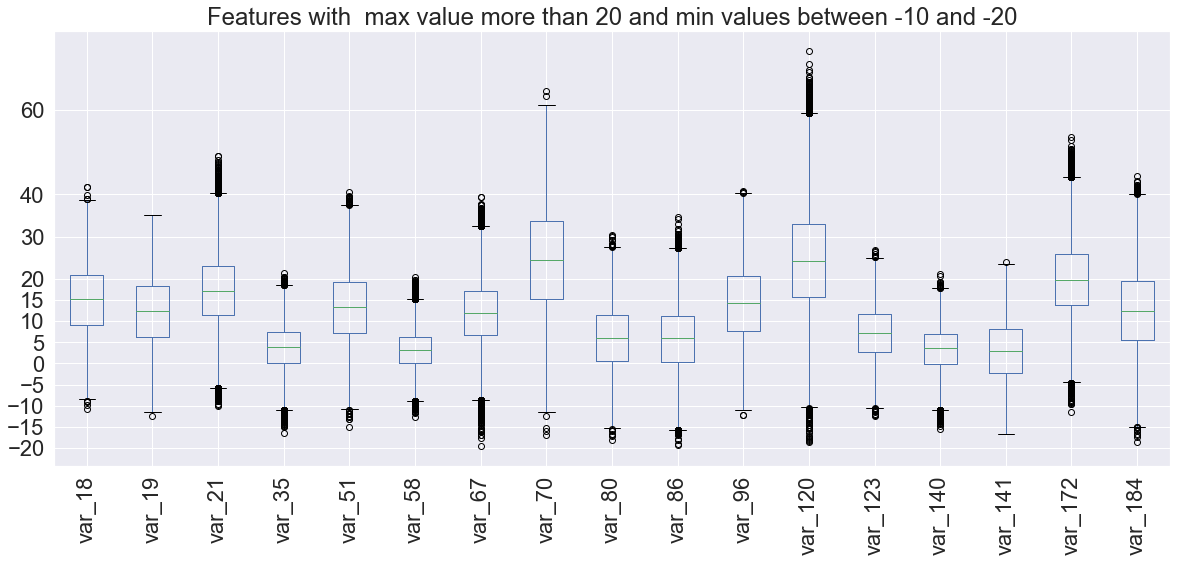

In [26]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setplustwentymoreminustwenty=train_data.loc[:,colplustwentymoreminustwenty].boxplot(rot=90)
setplustwentymoreminustwenty=setplustwentymoreminustwenty.set(
    yticks=[-20,-15,-10,-5,0,5,10,15,20,30,40,60],
    title="Features with  max value more than 20 and min values between -10 and -20"
)

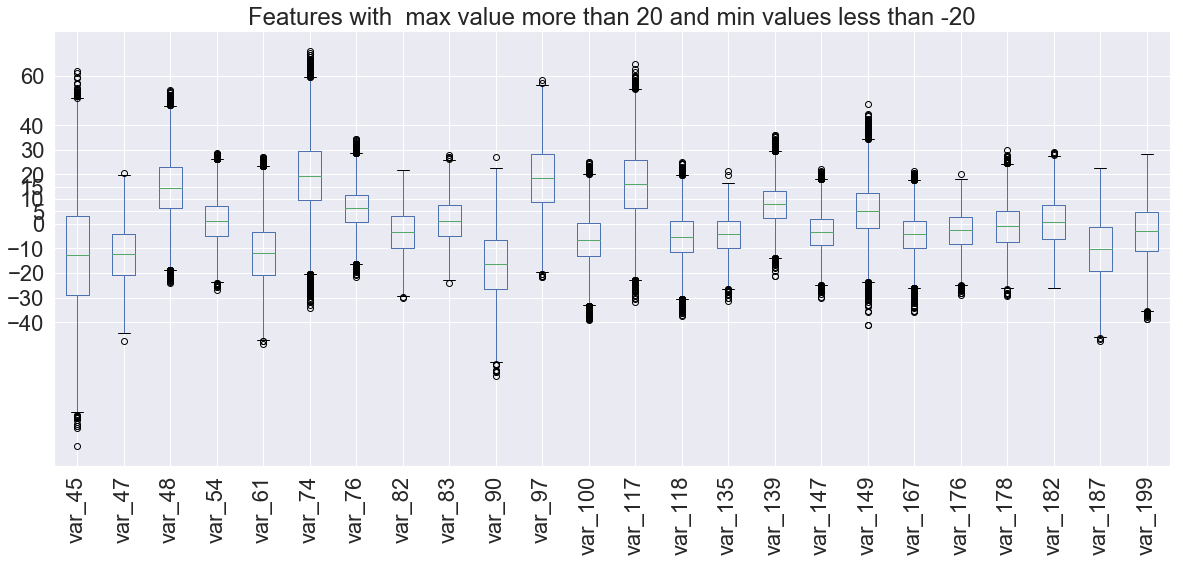

In [27]:
sns.set(rc={'figure.figsize':(20,8)}, font_scale=2)
setplustwentymoreminustwentymore=train_data.loc[:,colplustwentymoreminustwentymore].boxplot(rot=90)
setplustwentymoreminustwentymore=setplustwentymoreminustwentymore.set(
    yticks=[-40,-30,-20,-10,0,5,10,15,20,30,40,60],
    title="Features with  max value more than 20 and min values less than -20"
)

### Observations:
- Some boxplots show numerous outliers, and some show very small variation between samples.
- The most common case is positive features with a max between 10 and 20
- There are no purely negative features

## Lets analyze the following statistics on both the train and test data:
- mean
- std
- min
- max
- skew - Is the distribution right-leaning (negative) or left-leaning (positive)
- kurtosis - Are the tails of the distribution large or small? below 0 means light tails.

### Lets Examine Mean and Standard Deviation Distribution

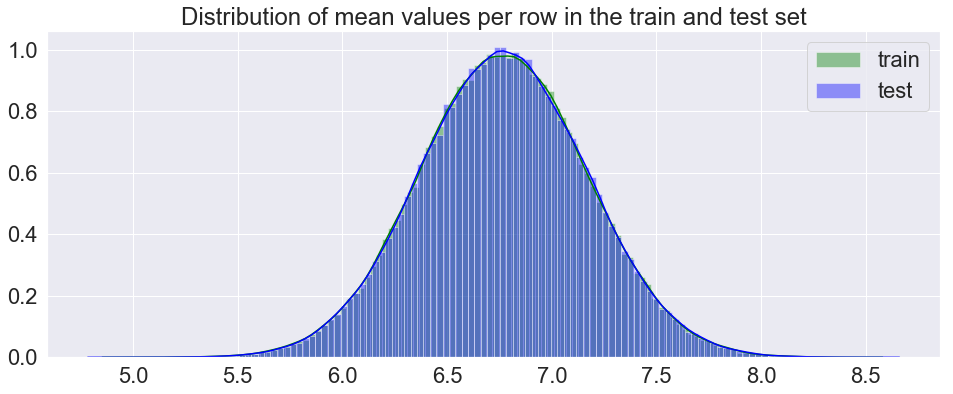

In [28]:
plt.figure(figsize=(16,6))
features = train_data.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_data[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_data[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

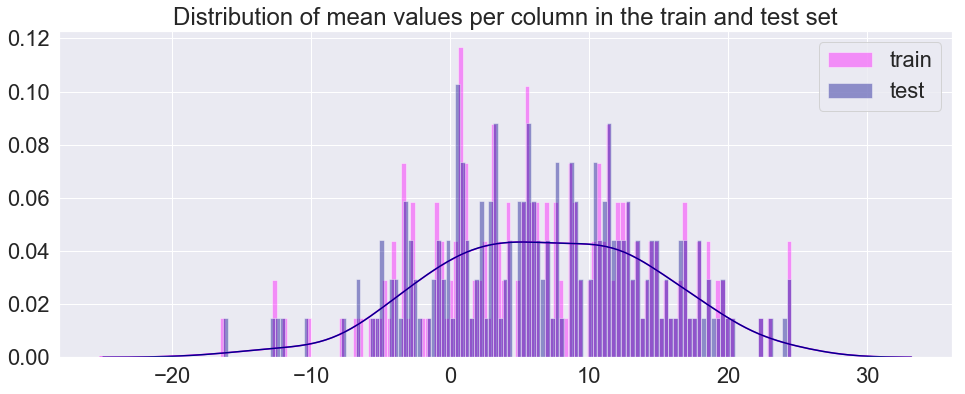

In [29]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_data[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_data[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

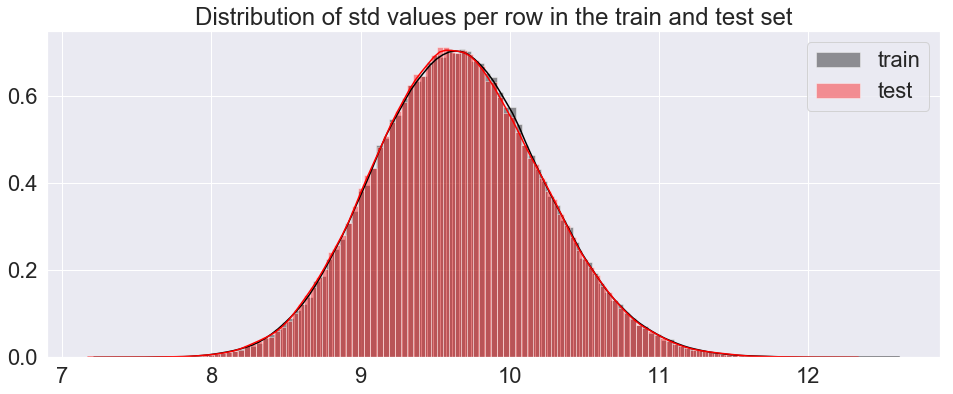

In [30]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_data[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_data[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

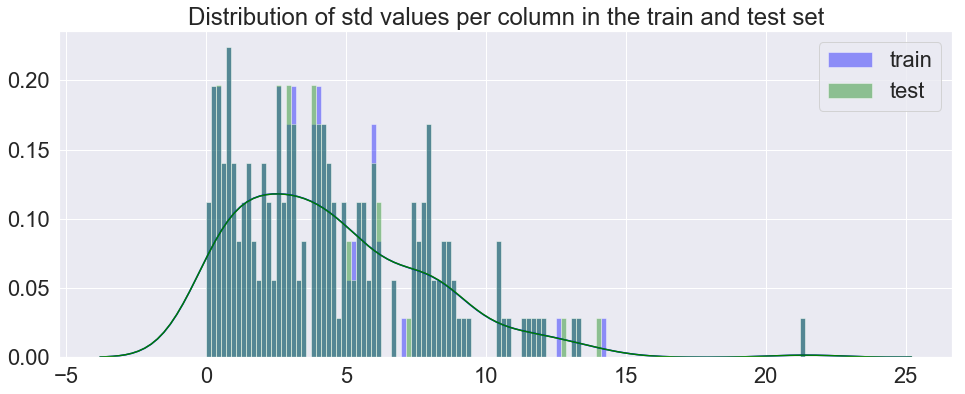

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_data[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_data[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

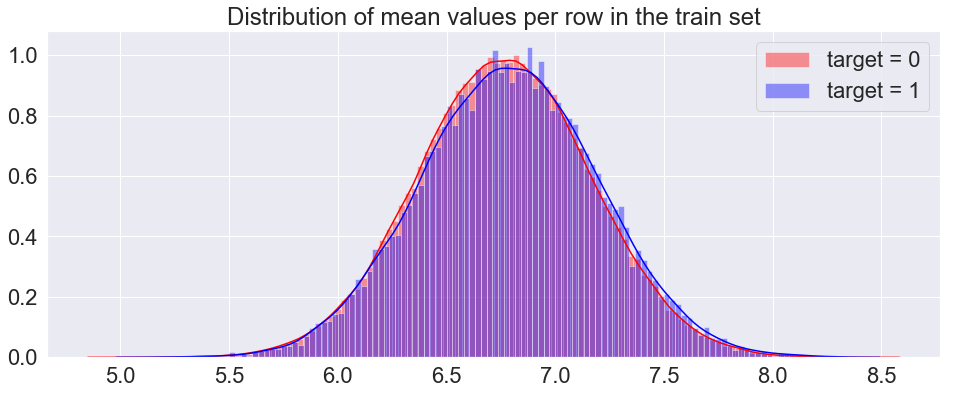

In [32]:
t0 = train_data.loc[train_data['target'] == 0]
t1 = train_data.loc[train_data['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

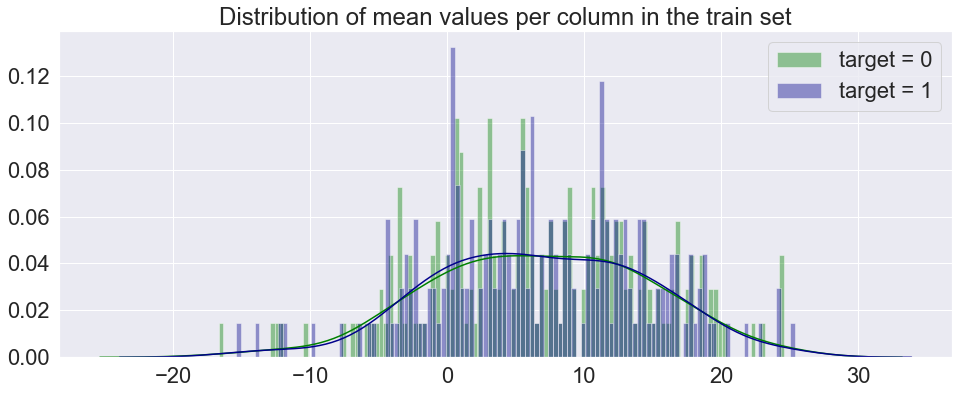

In [33]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Lets Examine Min and Max Distribution

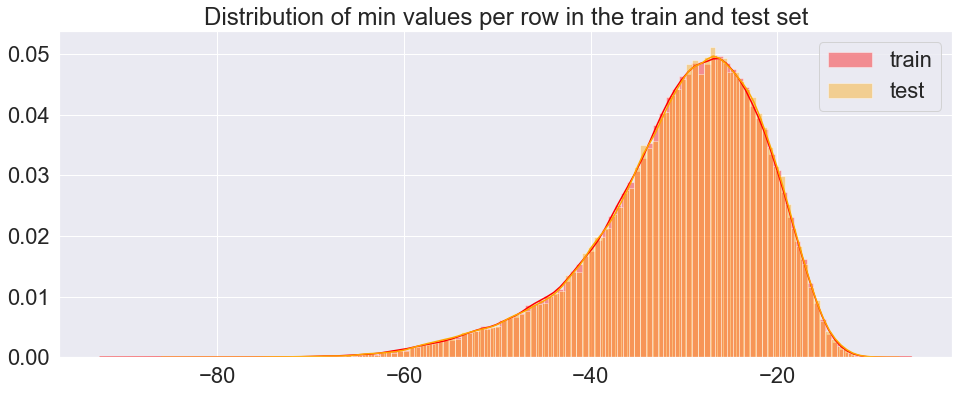

In [34]:
plt.figure(figsize=(16,6))
features = train_data.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_data[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_data[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

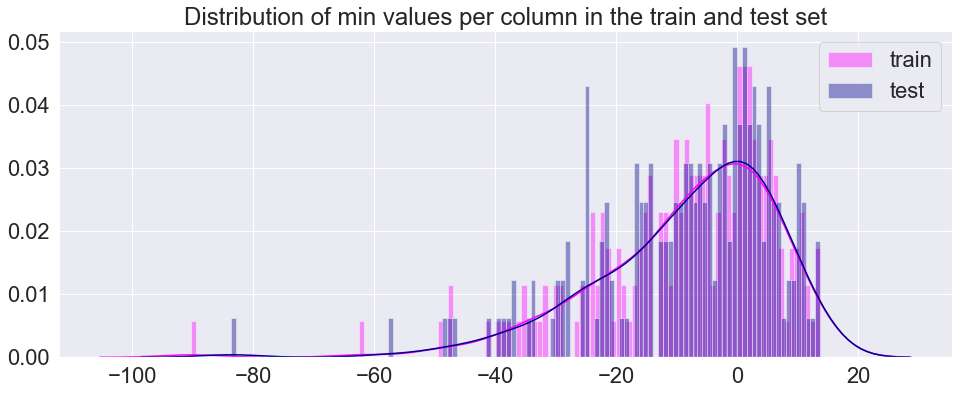

In [35]:
plt.figure(figsize=(16,6))
features = train_data.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_data[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_data[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

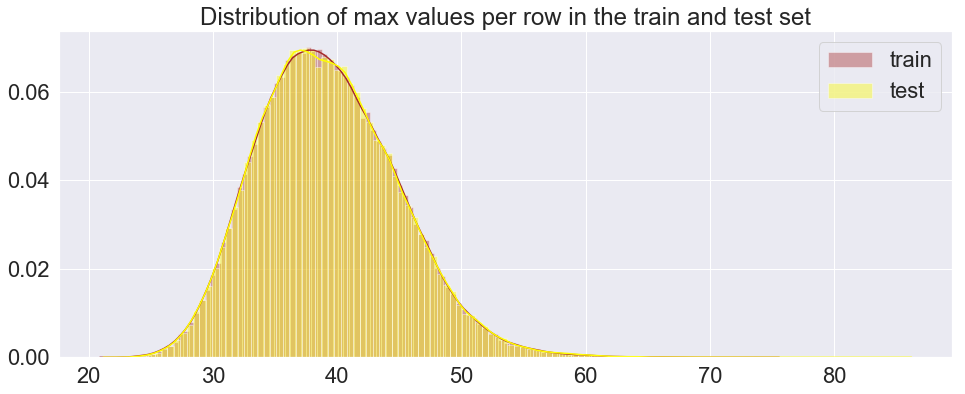

In [36]:
plt.figure(figsize=(16,6))
features = train_data.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_data[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_data[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

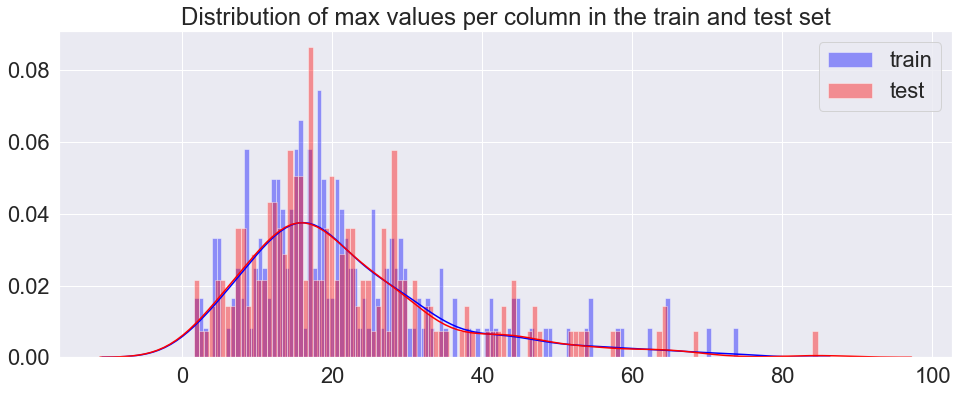

In [37]:
plt.figure(figsize=(16,6))
features = train_data.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_data[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_data[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

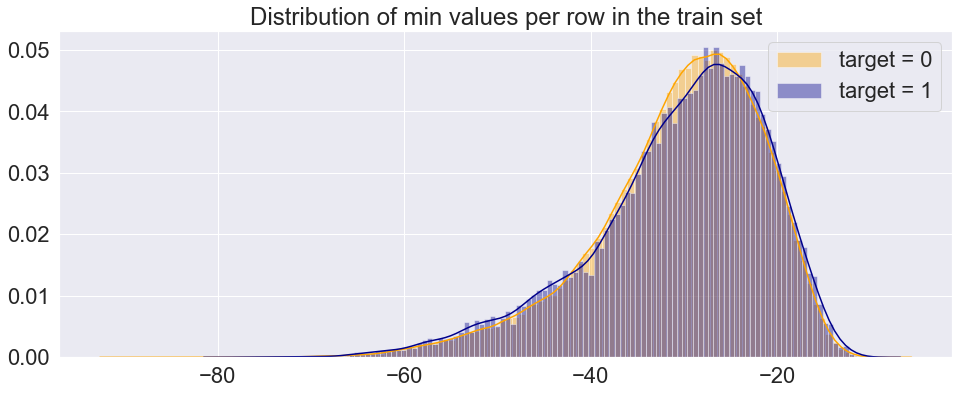

In [38]:
t0 = train_data.loc[train_data['target'] == 0]
t1 = train_data.loc[train_data['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

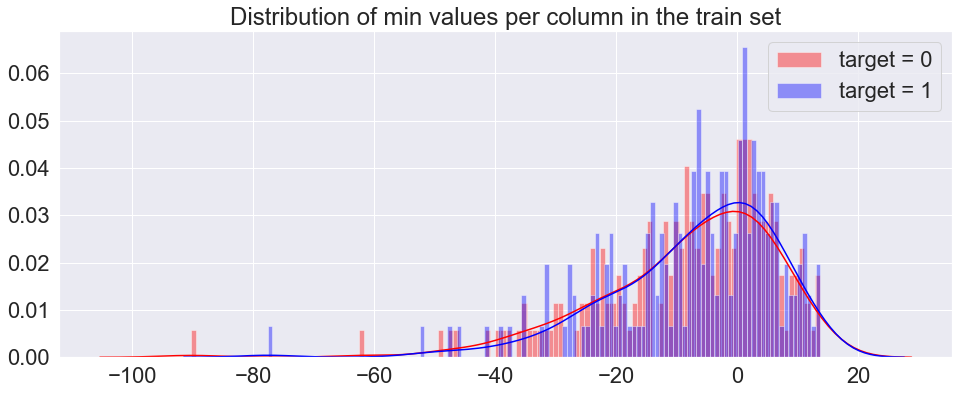

In [39]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

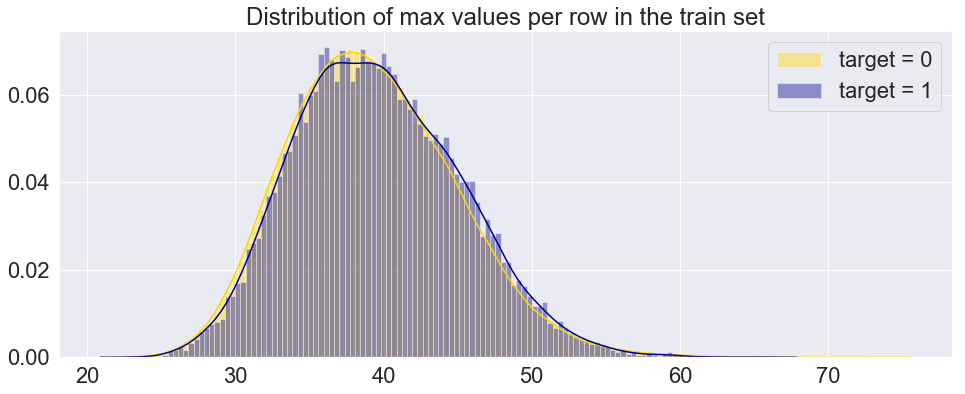

In [40]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

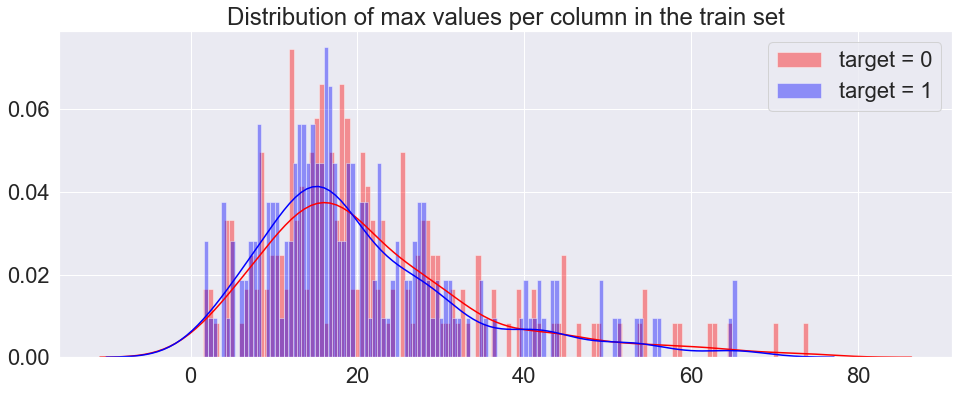

In [41]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Lets Examine Skew and Kurtosis

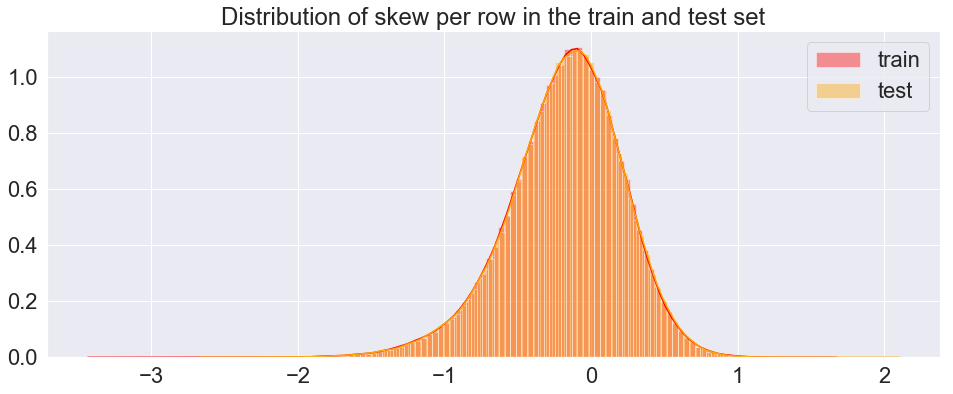

In [42]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_data[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_data[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

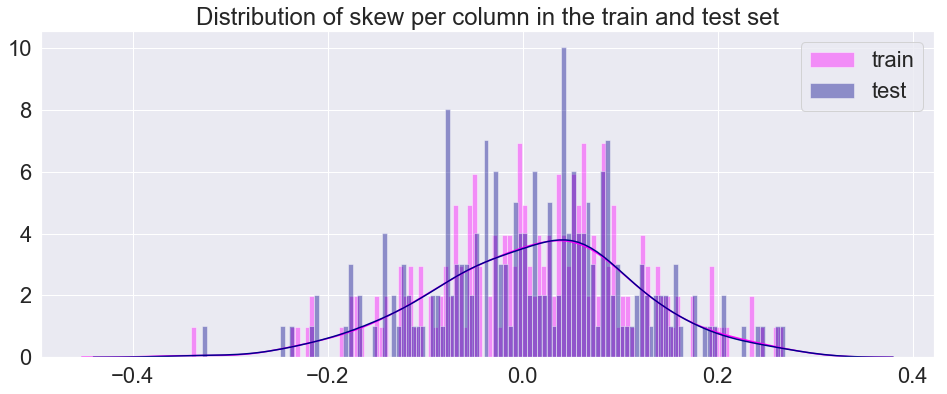

In [43]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_data[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_data[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

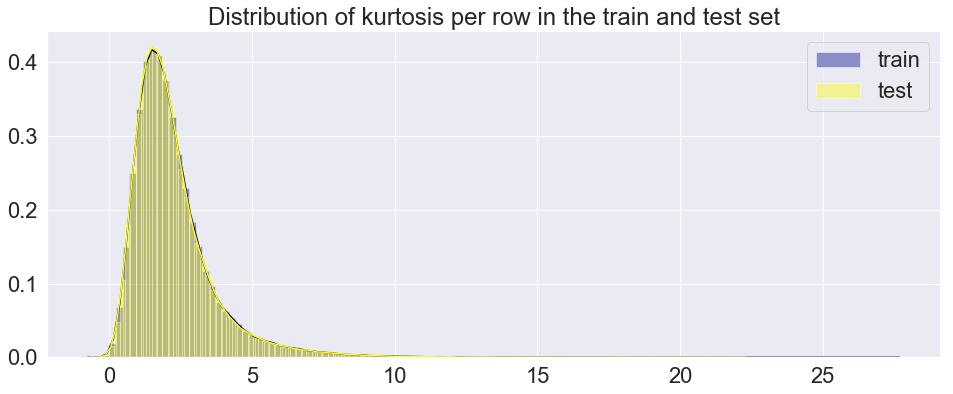

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_data[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_data[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

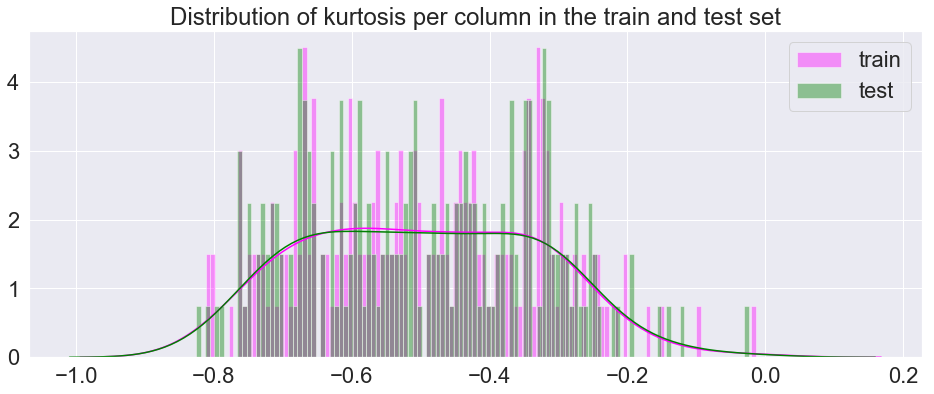

In [45]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_data[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_data[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

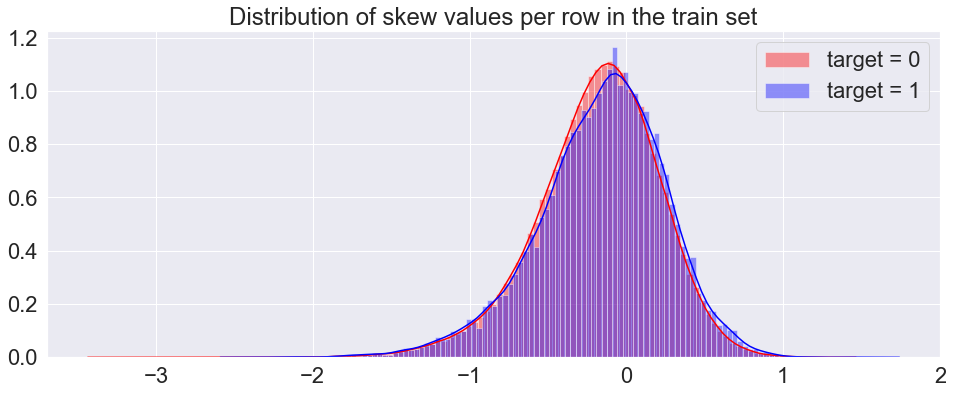

In [46]:
t0 = train_data.loc[train_data['target'] == 0]
t1 = train_data.loc[train_data['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

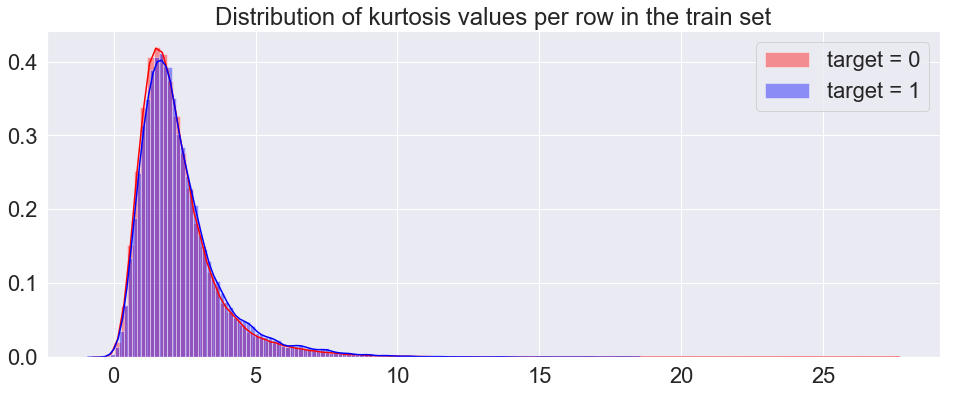

In [47]:
t0 = train_data.loc[train_data['target'] == 0]
t1 = train_data.loc[train_data['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

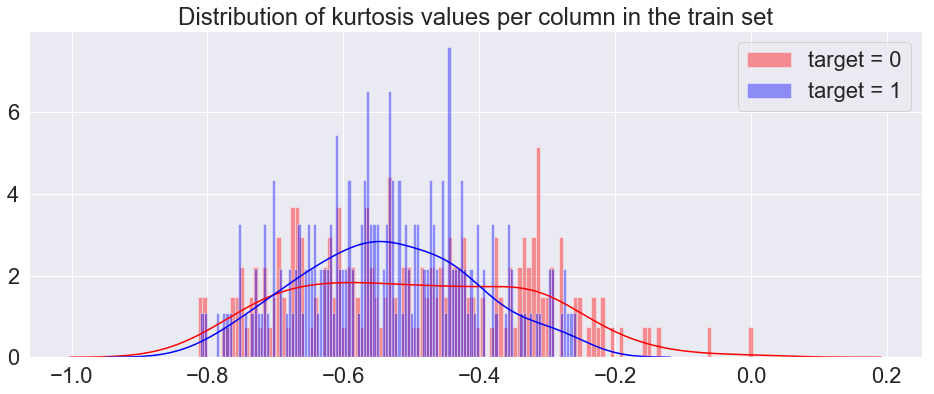

In [48]:
t0 = train_data.loc[train_data['target'] == 0]
t1 = train_data.loc[train_data['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### Observations:
- There is little to no differences when examining by row.
- There are some noticable diffrerences when examining by column, but no significant patterns
- There are some noticable diffrerences when examining by target, but no significant patterns
- The most notable difference overall is the kurtosis values per column in the training set

## Feature Engineering:

<hr>

### Add new features to each row in train and test data

In [49]:
# Define feature names
features = train_data.columns.values[2:202]

# Create a function to make new features with train and test data as inputs
def create_features(df):    
    df["sum"] = df[features].sum(axis=1)
    df["min"] = df[features].min(axis=1)
    df["max"] = df[features].max(axis=1)
    df["mean"] = df[features].mean(axis=1)
    df["std"] = df[features].std(axis=1)
    df["Q1"] = df[features].quantile(q =.25, axis=1)
    df["median"] = df[features].median(axis=1)
    df["Q3"] = df[features].quantile(q=.75, axis=1)
    df["skew"] = df[features].skew(axis=1)
    df["kurtosis"] = df[features].kurtosis(axis=1)
    
    return df

In [50]:
# Run create features for each dataset:
for df in [train_data, test_data]:
    create_features(df)

In [51]:
train_data.iloc[:,202:].head()

,sum,min,max,mean,std,Q1,median,Q3,skew,kurtosis
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,1.943775,6.77040,12.907925,0.101580,1.331023
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,1.914350,7.22315,12.233050,-0.351734,4.110215
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,1.050075,5.89940,11.939050,-0.056957,0.546438
3,1288.2319,-35.1659,38.1015,6.441160,9.594064,1.557375,6.70260,12.187575,-0.480116,2.630499
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,1.463625,6.94735,12.754150,-1.463426,9.787399


In [52]:
test_data.iloc[:,201:].head()

,sum,min,max,mean,std,Q1,median,Q3,skew,kurtosis
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,1.389900,7.31440,13.058850,-0.088518,1.871262
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,1.504200,6.43960,11.674975,-0.559785,3.391068
2,1430.2599,-34.3488,39.3654,7.151300,9.967466,1.437000,7.26355,12.757375,-0.135084,2.326901
3,1411.4447,-21.4797,40.3383,7.057224,8.257204,2.500825,6.89675,12.566575,-0.167741,2.253054
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,1.434825,6.83375,12.673100,0.293484,2.044943


### What are the distributions of our new features by TARGET:

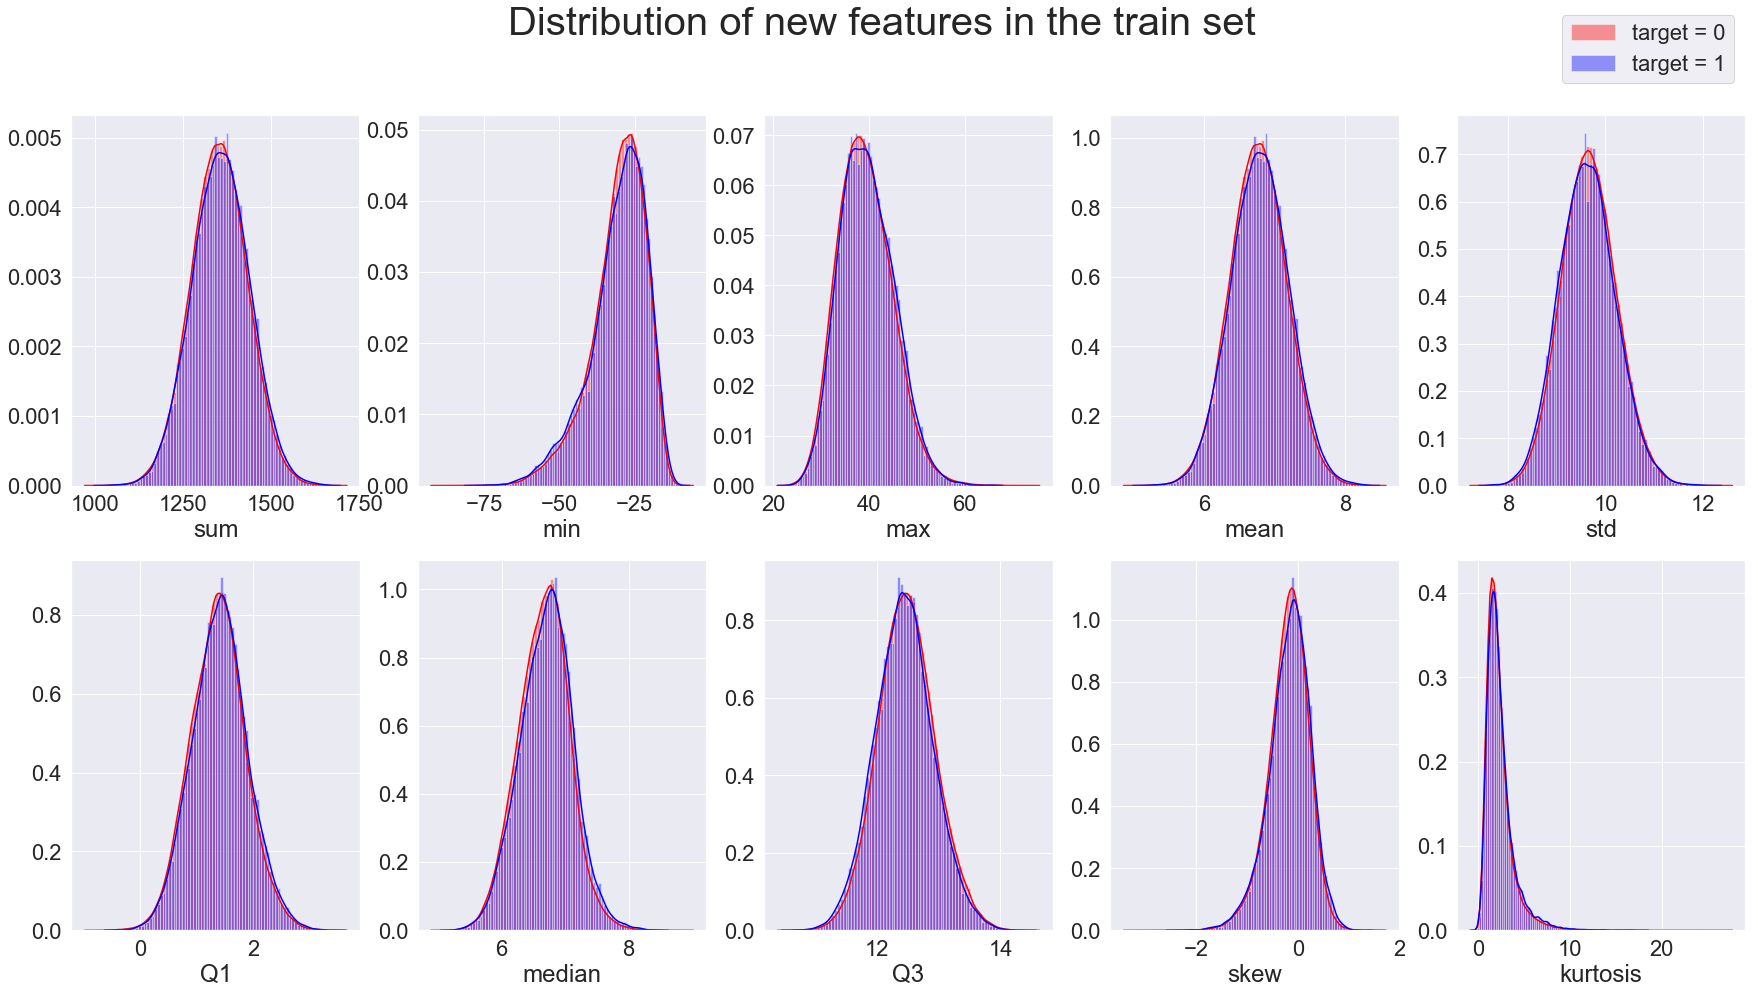

In [53]:
# define 0 target and 1 target values
train_data_target_0 = train_data.loc[train_data['target'] == 0]
train_data_target_1 = train_data.loc[train_data['target'] == 1]

fig, axes = plt.subplots(2, 5, figsize=(30,15))
fig.suptitle("Distribution of new features in the train set", fontsize=40)

for idx in range(0,10):
    
    if idx < 5:
        N=0; M=idx
    else:
        N=1; M=idx-5
    
    sns.distplot(
        train_data_target_0.iloc[:,202+idx], 
        color="red", 
        kde=True, 
        bins=80, 
        label='target = 0',
        ax = axes[N][M]
    )
    sns.distplot(
        train_data_target_1.iloc[:,202+idx], 
        color="blue", 
        kde=True, 
        bins=80,
        label='target = 1',
        ax = axes[N][M]
    )
    

axes[0][4].legend(loc="upper right", bbox_to_anchor=(1,1.3))
plt.show()

### What are the distributions by Train and Test:

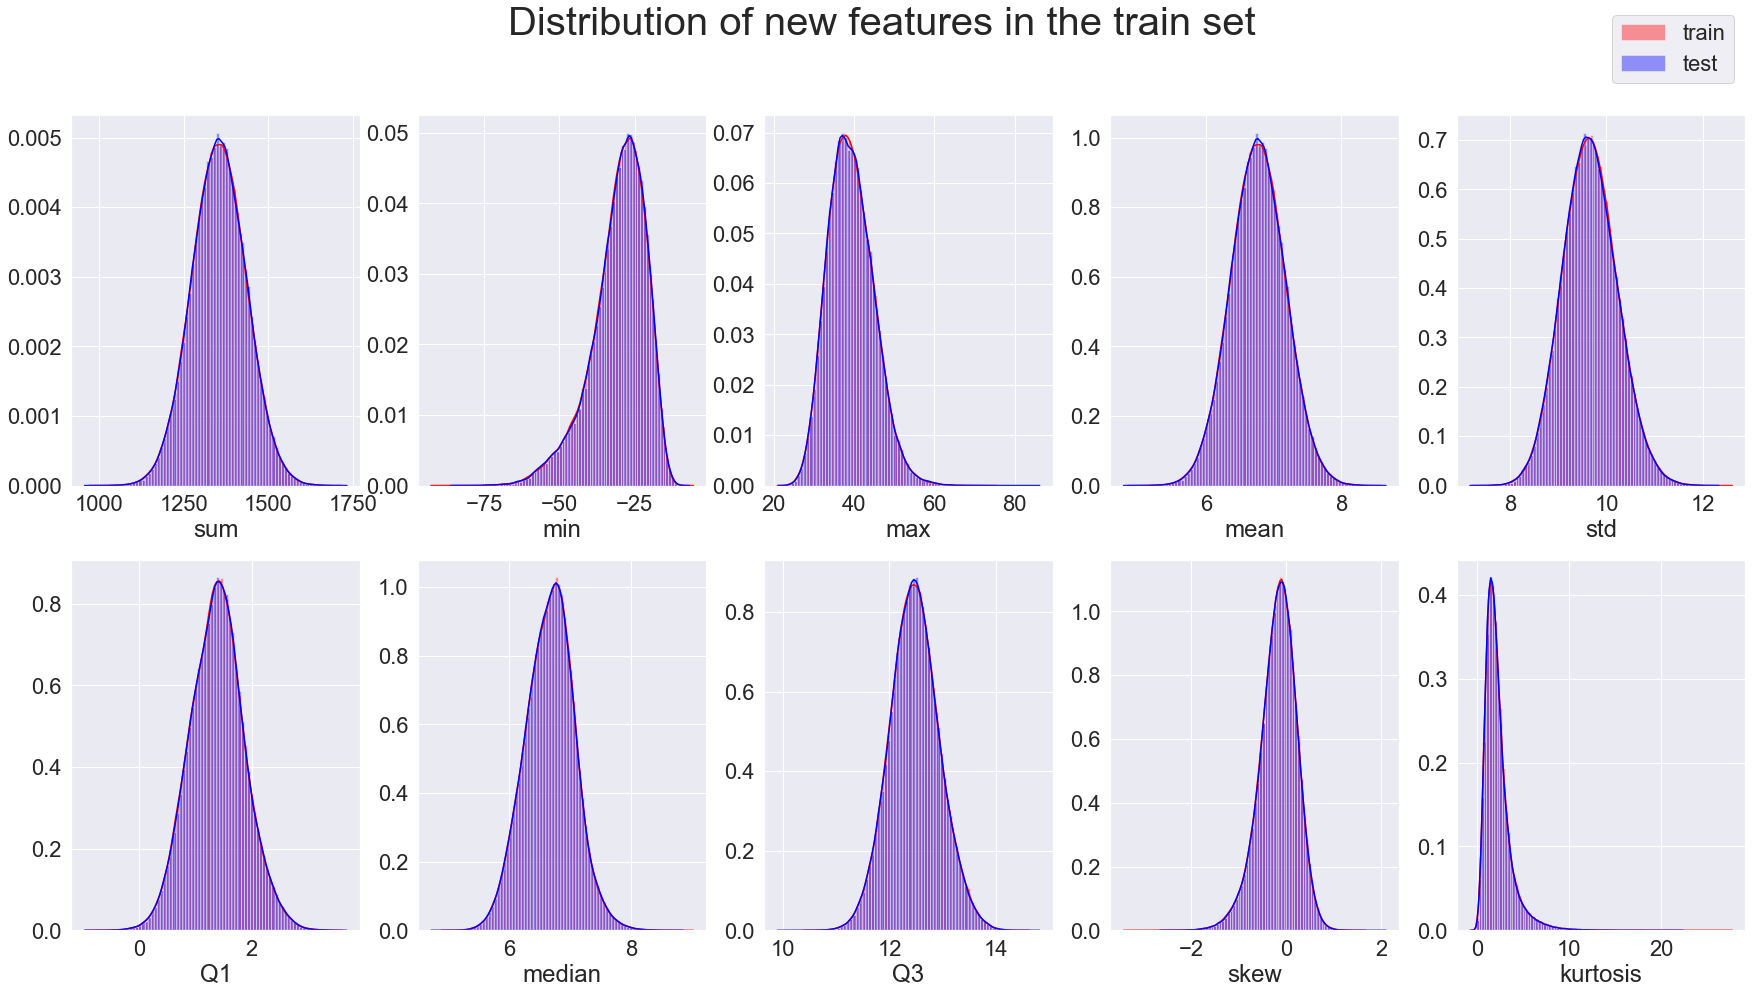

In [54]:
fig, axes = plt.subplots(2, 5, figsize=(30,15))
fig.suptitle("Distribution of new features in the train set", fontsize=40)

for idx in range(0,10):
    
    if idx < 5:
        N=0; M=idx
    else:
        N=1; M=idx-5
    
    sns.distplot(
        train_data.iloc[:,202+idx], 
        color="red", 
        kde=True, 
        bins=80, 
        label='train',
        ax = axes[N][M]
    )
    sns.distplot(
        test_data.iloc[:,201+idx], 
        color="blue", 
        kde=True, 
        bins=80,
        label='test',
        ax = axes[N][M]
    )
    

axes[0][4].legend(loc="upper right", bbox_to_anchor=(1,1.3))
plt.show()

### Observations:
- There are minimal differences between 0 and 1 targets for newly generated features, but they add an extra unique element to each sample.
- For now it is worth adding to the dataset. Later we will discover if these features were of any importance.

In [55]:
# Must redefine X_train and y_train in order to use these new features.
X = train_data.drop(columns=["ID_code","target"])
y = train_data.target

# Split X and y into Train Data and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (140000, 210)
Test shape: (60000, 210)


<hr>

## UnderSampling & OverSampling:

### Given the imbalanced Dataset, can we somehow make it balanced?
- Must use X_train data we have previously defined. Otherwise Our model will find exact matches when Oversampling.

### Undersample:

In [56]:
# Use X_train data from earlier to Undersample
rus = RandomUnderSampler(sampling_strategy="majority") # We only want to decrease the majority class
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

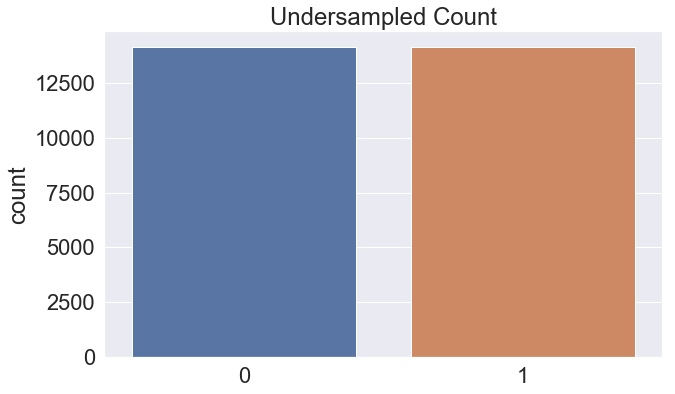

In [57]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x=y_train_rus, ax=ax)
ax.set_title("Undersampled Count")
plt.show()

In [58]:
print(f"Number of datapoints lost due to undersampling: {len(X_train) - len(X_train_rus)}")
print("Percentage of datapoints lost: {0:.2%}".format((len(X_train) - len(X_train_rus))/len(X_train)))

Number of datapoints lost due to undersampling: 111726
Percentage of datapoints lost: 79.80%


### Observations:
- Undersampling created an even distribution among target values.
- However, Lost nearly 80% of datapoints

### Oversample with SMOTE:

In [59]:
# Use X_train data from earlier to Undersample
smote = SMOTE(sampling_strategy="minority") # We only want to increase the minority class
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

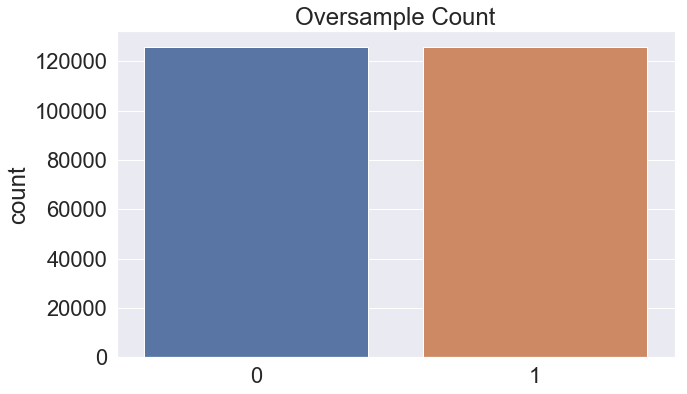

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x=y_train_sm, ax=ax)
ax.set_title("Oversample Count")
plt.show()

In [61]:
print("Total number of datapoints is now: {0}".format(len(X_train_sm)))
print("Percentage of datapoints Gained: {0:.2%}".format((len(X_train_sm) - len(X_train))/len(X_train)))

Total number of datapoints is now: 251726
Percentage of datapoints Gained: 79.80%


#### Lets see the new distribution of some variables after oversampling:

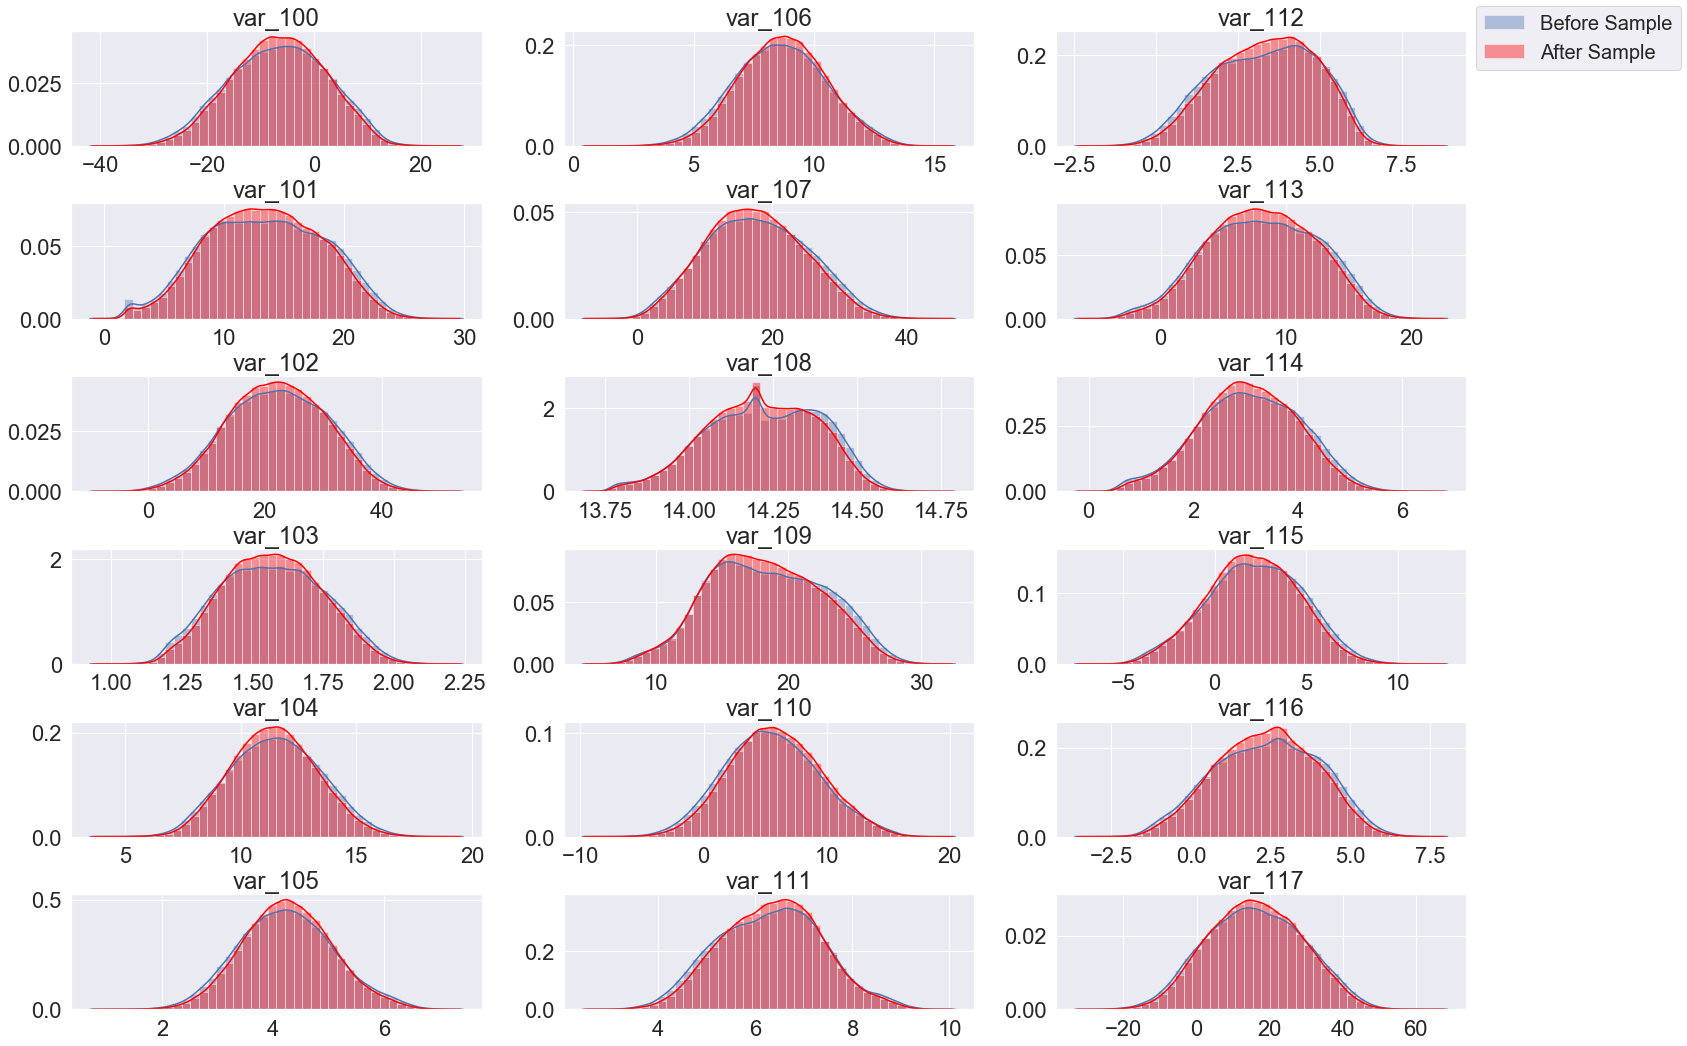

In [62]:
# Convert to dataframes
X_train_df = pd.DataFrame(X_train)
X_train_sm_df = pd.DataFrame(X_train_sm, columns=X_train_df.columns.values)

sns.set_style(style="darkgrid")
fig, axes= plt.subplots(6,3,figsize=(25,18))

# Pick N in between 0 and 200-18
N = 100

bin_size = 40

for count in range(0,18):
    if count < 6:
        i = count
        j = 0
    elif count < 12:
        i = count - 6
        j = 1
    else:
        i = count - 12
        j = 2
        
    sns.distplot(X_train_df.iloc[:,N+count], ax=axes[i][j], bins = bin_size, label="Before Sample")
    sns.distplot(X_train_sm_df.iloc[:,N+count], ax=axes[i][j], color="red", bins=bin_size, label="After Sample")
    axes[i][j].set_title(X_train_sm_df.iloc[:,N+count].name)
    axes[i][j].set_xlabel("")

# Add Legend for Enture figure
axes[0][2].legend(["Before Sample","After Sample"], bbox_to_anchor=(1,1.3), fontsize="small")

# Adjust space between subplot
plt.subplots_adjust(hspace=0.5)
plt.show()

### Observations:
- Gained several more features to the training data. by 80%
- Distribution for each variable seems to be more concentrated around the mean of the distrbution. (with some minor exceptions)

### Combined Over and Undersampling:

In [63]:
smote_tomek = SMOTETomek(sampling_strategy="auto")
X_train_smt, y_train_smt = smote_tomek.fit_sample(X_train, y_train)

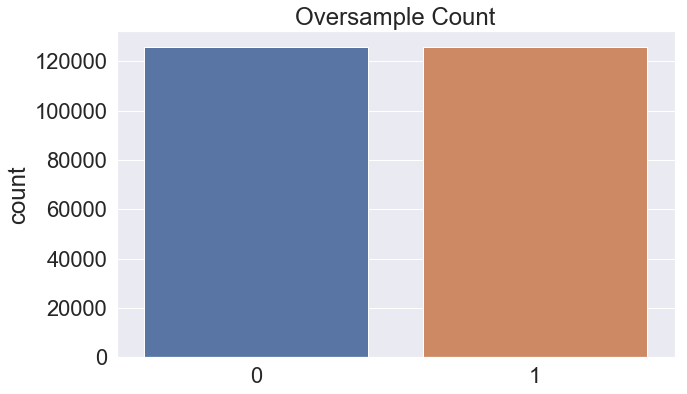

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x=y_train_smt, ax=ax)
ax.set_title("Oversample Count")
plt.show()

In [65]:
print("Total number of datapoints is now: {0}".format(len(X_train_smt)))
print("Difference Before and After SMOTETomek is: {0}".format(len(X_train_smt) - len(X_train)))

Total number of datapoints is now: 251726
Difference Before and After SMOTETomek is: 111726


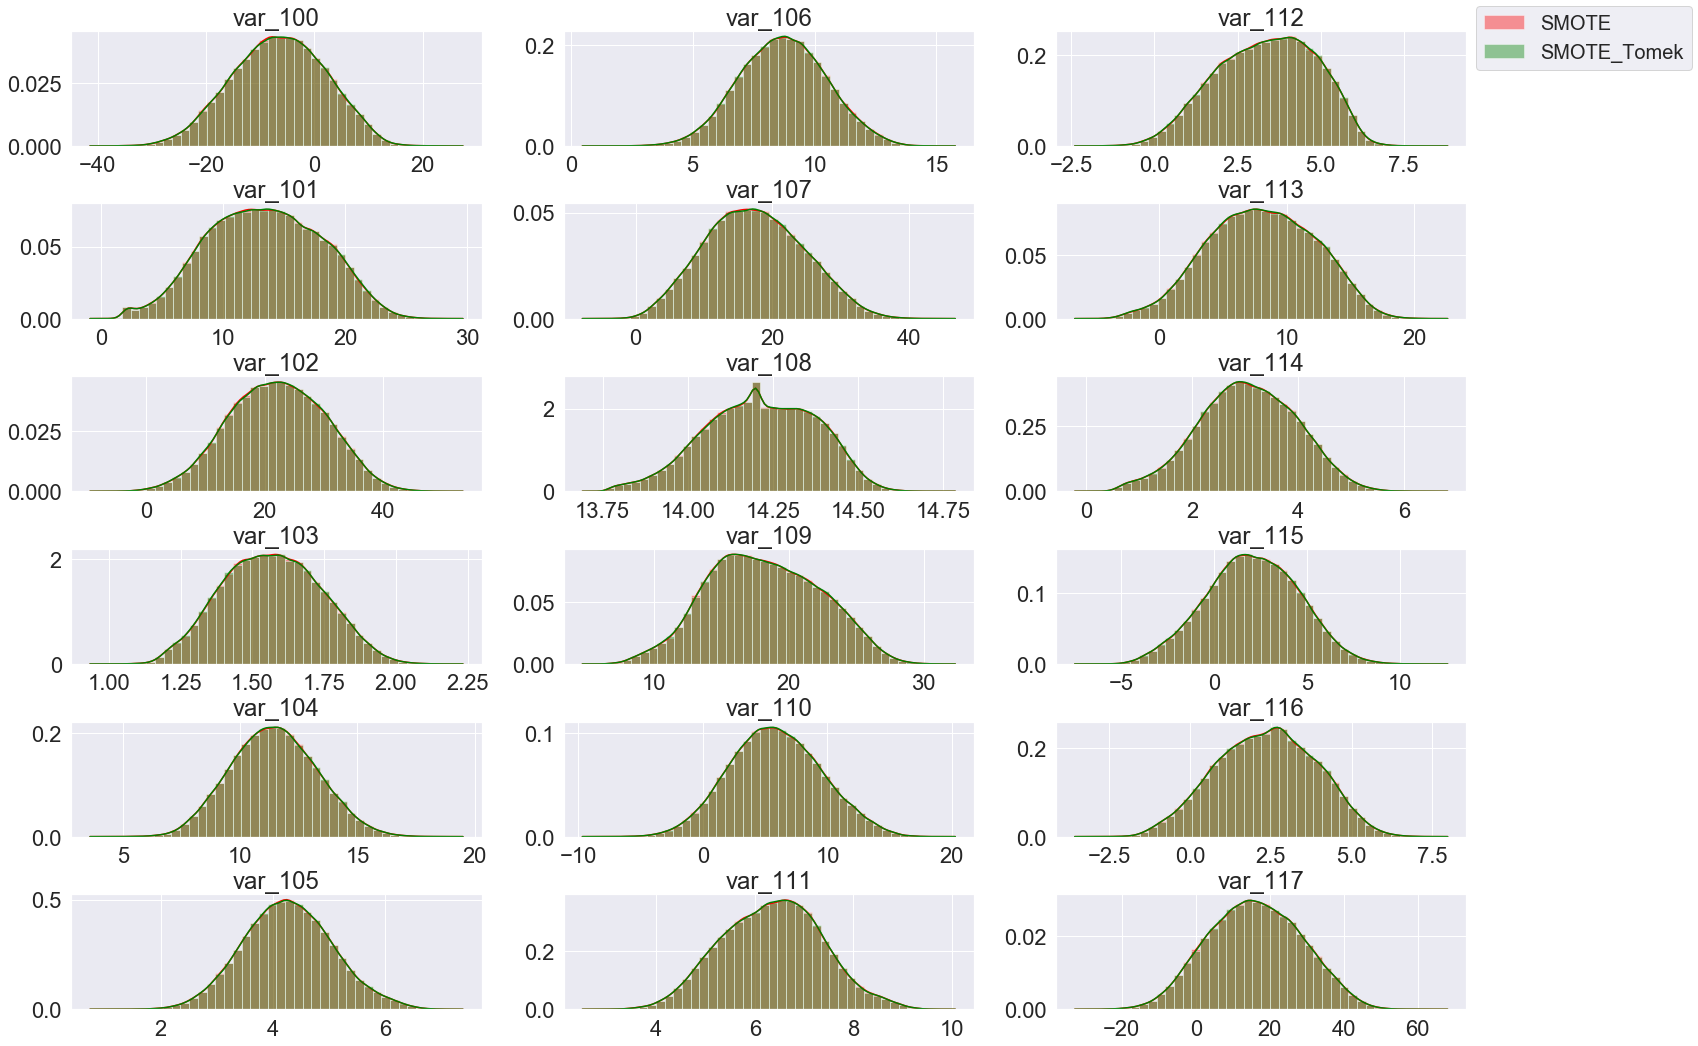

In [66]:
# Convert to dataframes
X_train_df = pd.DataFrame(X_train)
X_train_sm_df = pd.DataFrame(X_train_sm, columns=X_train_df.columns.values)
X_train_smt_df = pd.DataFrame(X_train_smt, columns=X_train_df.columns.values)

sns.set_style(style="darkgrid")
fig, axes= plt.subplots(6,3,figsize=(25,18))

# Pick N in between 0 and 200-18
N = 100

bin_size = 40

for count in range(0,18):
    if count < 6:
        i = count
        j = 0
    elif count < 12:
        i = count - 6
        j = 1
    else:
        i = count - 12
        j = 2
        
    sns.distplot(X_train_sm_df.iloc[:,N+count], ax=axes[i][j], color="red", bins=bin_size, label="SMOTE")
    sns.distplot(X_train_smt_df.iloc[:,N+count], ax=axes[i][j], color="green", bins=bin_size, label="SMOTE_Tomek")
    
    axes[i][j].set_title(X_train_sm_df.iloc[:,N+count].name)
    axes[i][j].set_xlabel("")

# Add Legend for Enture figure
axes[0][2].legend(["SMOTE", "SMOTE_Tomek"], bbox_to_anchor=(1,1.3), fontsize="small")

# Adjust space between subplot
plt.subplots_adjust(hspace=0.5)
plt.show()

### Observations:
- SMOTE Oversampling was very effective. However the combination does not seem to differ much at all.
- SMOTE_Tomek and SMOTE generated the exact same number of samples, and nearly identical distributions.
- Very suddle hints of red in the above plot indicate theses datasets are not exactly the same.

<hr>

## Algorithms:

For Each Algorithm:
- Define classification technique
- Useful Parameters
- Pros / Cons
- Classification Report Analysis

#### Lets use the same train_test_split as we did before and try algorithms again:

In [67]:
# Define an empty dictionary to store predictions:
algo_dict = {}

### Logistic Regresssion:

In [68]:
# Fit and calculate predictions to the model
logmodel = LogisticRegression(C=0.001, class_weight="balanced")
logmodel.fit(X_train_smt, y_train_smt)
predictions = logmodel.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["LogisticRegression"] = predictions

# print the score
print(logmodel.score(X_test, y_test))
print()
print(classification_report(y_test, logmodel.predict(X_test)))

0.7841333333333333

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     54039
           1       0.28      0.75      0.41      5961

   micro avg       0.78      0.78      0.78     60000
   macro avg       0.62      0.77      0.64     60000
weighted avg       0.90      0.78      0.82     60000



### Decision Tree:

In [69]:
# Fit and calculate predictions to the model
dtree = DecisionTreeClassifier(class_weight="balanced")
dtree.fit(X_train_smt, y_train_smt)
predictions = dtree.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["DecisionTree"] = predictions

# print the score
print(dtree.score(X_test, y_test))
print()
print(classification_report(y_test, dtree.predict(X_test)))

0.70455

              precision    recall  f1-score   support

           0       0.91      0.75      0.82     54039
           1       0.12      0.33      0.18      5961

   micro avg       0.70      0.70      0.70     60000
   macro avg       0.52      0.54      0.50     60000
weighted avg       0.83      0.70      0.76     60000



### Random Forest - for now lets use 15 trees:

In [70]:
# Fit and calculate predictions to the model
N = 15
rforest = RandomForestClassifier(n_estimators=N, class_weight="balanced")
rforest.fit(X_train_smt, y_train_smt)
predictions = rforest.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict[f"RandomForest_N{str(N)}"] = predictions

# print the score
print(rforest.score(X_test, y_test))
print()
print(classification_report(y_test, rforest.predict(X_test)))

0.85835

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     54039
           1       0.19      0.13      0.16      5961

   micro avg       0.86      0.86      0.86     60000
   macro avg       0.55      0.54      0.54     60000
weighted avg       0.84      0.86      0.85     60000



### SVM Linear:

In [71]:
# Fit and calculate the model
svclinear = LinearSVC(C=0.0001, tol=1e-5, class_weight="balanced")
clf_svclinear = CalibratedClassifierCV(svclinear)
clf_svclinear.fit(X_train_smt, y_train_smt)
predictions = clf_svclinear.predict_proba(X_test)[:,1]

# Move predictions to algo_dict
algo_dict["LinearSVC"] = predictions

# print the score
print(clf_svclinear.score(X_test, y_test))
print()
print(classification_report(y_test, clf_svclinear.predict(X_test)))

0.7836833333333333

              precision    recall  f1-score   support

           0       0.97      0.79      0.87     54039
           1       0.28      0.75      0.41      5961

   micro avg       0.78      0.78      0.78     60000
   macro avg       0.62      0.77      0.64     60000
weighted avg       0.90      0.78      0.82     60000



### SGDClassifier:

In [72]:
# Fit and calculate the model
sgd_clf = SGDClassifier(loss="log", class_weight="balanced", penalty="l2", tol=1e-5, max_iter=5)
sgd_clf.fit(X_train_smt, y_train_smt)
predictions = sgd_clf.predict_proba(X_test)[:,1]


algo_dict["SGDClassifier"] = predictions

# print the score
print(sgd_clf.score(X_test, y_test))
print()
print(classification_report(y_test, sgd_clf.predict(X_test)))

0.23568333333333333

              precision    recall  f1-score   support

           0       0.99      0.15      0.26     54039
           1       0.11      0.99      0.20      5961

   micro avg       0.24      0.24      0.24     60000
   macro avg       0.55      0.57      0.23     60000
weighted avg       0.90      0.24      0.26     60000



### LightGBM:

In [73]:
param = {
        'num_leaves': 6,
        'max_bin': 63,
        'min_data_in_leaf': 45,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.000446,
        'bagging_fraction': 0.55, 
        'bagging_freq': 5, 
        'max_depth': 14,
        'save_binary': True,
        'seed': 31452,
        'feature_fraction_seed': 31415,
        'feature_fraction': 0.51,
        'bagging_seed': 31415,
        'drop_seed': 31415,
        'data_random_seed': 31415,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
    }

In [74]:
# Fit and calculate the model
lgb_model = lgb.LGBMClassifier(**param, n_estimators = 15000, n_jobs = -1)
lgb_model.fit(X_train_smt, y_train_smt, eval_set=[(X_train_smt, y_train_smt), (X_test, y_test)], verbose=1000, early_stopping_rounds=200)

predictions = lgb_model.predict_proba(X_test)[:,1]

algo_dict["LGBMClassifier"] = predictions

# print the score
print(lgb_model.score(X_test, y_test))
print()
print(classification_report(y_test, lgb_model.predict(X_test)))

Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.925087	valid_1's auc: 0.688683
[2000]	training's auc: 0.940666	valid_1's auc: 0.712466
[3000]	training's auc: 0.948593	valid_1's auc: 0.73177
[4000]	training's auc: 0.953732	valid_1's auc: 0.747038
[5000]	training's auc: 0.957371	valid_1's auc: 0.758613
[6000]	training's auc: 0.960333	valid_1's auc: 0.768582
[7000]	training's auc: 0.962655	valid_1's auc: 0.776259
[8000]	training's auc: 0.964567	valid_1's auc: 0.782441
[9000]	training's auc: 0.966251	valid_1's auc: 0.787375
[10000]	training's auc: 0.96775	valid_1's auc: 0.790924
[11000]	training's auc: 0.969205	valid_1's auc: 0.794545
[12000]	training's auc: 0.970615	valid_1's auc: 0.797676
[13000]	training's auc: 0.971962	valid_1's auc: 0.799887
[14000]	training's auc: 0.973251	valid_1's auc: 0.801949
[15000]	training's auc: 0.974501	valid_1's auc: 0.803864
Did not meet early stopping. Best iteration is:
[15000]	training's auc: 0.974501	valid_1's au

## Plot all algorithms on a ROC and PR curve:

In [75]:
def ROC_PR_Curves(y_test, algo_dict):
    # Creates the ROC vs. PC Curve chart above after all the models have been calculated and stored in algo_dict
    # algo_dict ex: {"Logistic_Regression": log_predictions, "KNN": knn_predictions, ...}
    
    # Create subplot using both the Precision Recall Curve and the Receiver Operating Characteristic
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        
    for label, predictions in algo_dict.items():
        
        # Create ROC curve
        fpr, tpr, thresholds = roc_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        AUC = np.round(auc(fpr, tpr), 4)
        sns.lineplot(x=fpr, y=tpr, ax=axes[0], label=f"{label} - AUC Score: {AUC}")

        # Create PR Curve
        p, r, threshold_pr = precision_recall_curve(y_test.ravel().reshape(-1,1), predictions.reshape(-1,1))
        sns.lineplot(x=p, y=r, ax=axes[1], label=label)
    
    # ROC Curve Axes Parameters
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_title("ROC Curve")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")
    axes[0].legend(loc="lower right", fontsize="small")
    
    # PR Curve Axes Parameters
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_title("Percision Recall Curve")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    axes[1].legend(loc="upper right", fontsize="small")

    # Display the Plot
    plt.show()
    
    return "Finished"

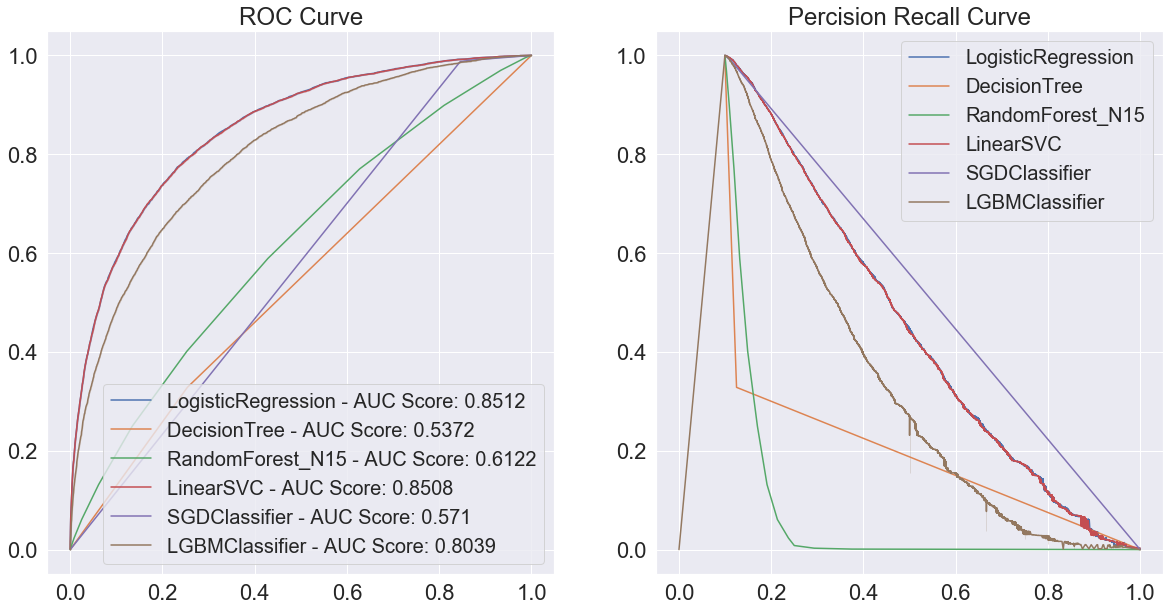

'Finished'

In [76]:
ROC_PR_Curves(y_test=y_test, algo_dict=algo_dict)

### Since LightGBM is our highest performer, let's use StratifiedKFolds for a better result:

In [77]:
# Define Features and Target in training data
features = [c for c in train_data.columns if c not in ['ID_code', 'target']]
target = train_data['target']

In [78]:
# Define Stratified K Folds. (Instead of using train_test_split, split data in 9 different combinations)
folds = StratifiedKFold(n_splits=9, shuffle=True, random_state=31415)

# Define Out-of-Fold length and prediction length
oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))
feature_importance_df = pd.DataFrame()

# Calculate each fold using the training index and validated index
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_data.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 250)
    oof[val_idx] = clf.predict(train_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_data[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold 0
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.861128	valid_1's auc: 0.848458
[2000]	training's auc: 0.890029	valid_1's auc: 0.873733
[3000]	training's auc: 0.902969	valid_1's auc: 0.883041
[4000]	training's auc: 0.910708	valid_1's auc: 0.888141
[5000]	training's auc: 0.915963	valid_1's auc: 0.891496
[6000]	training's auc: 0.919848	valid_1's auc: 0.89321
[7000]	training's auc: 0.922926	valid_1's auc: 0.8945
[8000]	training's auc: 0.925751	valid_1's auc: 0.895074
[9000]	training's auc: 0.92849	valid_1's auc: 0.895411
Early stopping, best iteration is:
[8840]	training's auc: 0.928056	valid_1's auc: 0.895456
Fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.861494	valid_1's auc: 0.844499
[2000]	training's auc: 0.889687	valid_1's auc: 0.871441
[3000]	training's auc: 0.902552	valid_1's auc: 0.882865
[4000]	training's auc: 0.910365	valid_1's auc: 0.88922
[5000]	training's auc: 0.915675	valid_1's auc:

In [79]:
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

CV score: 0.89846 


### What were the most important features in this model?

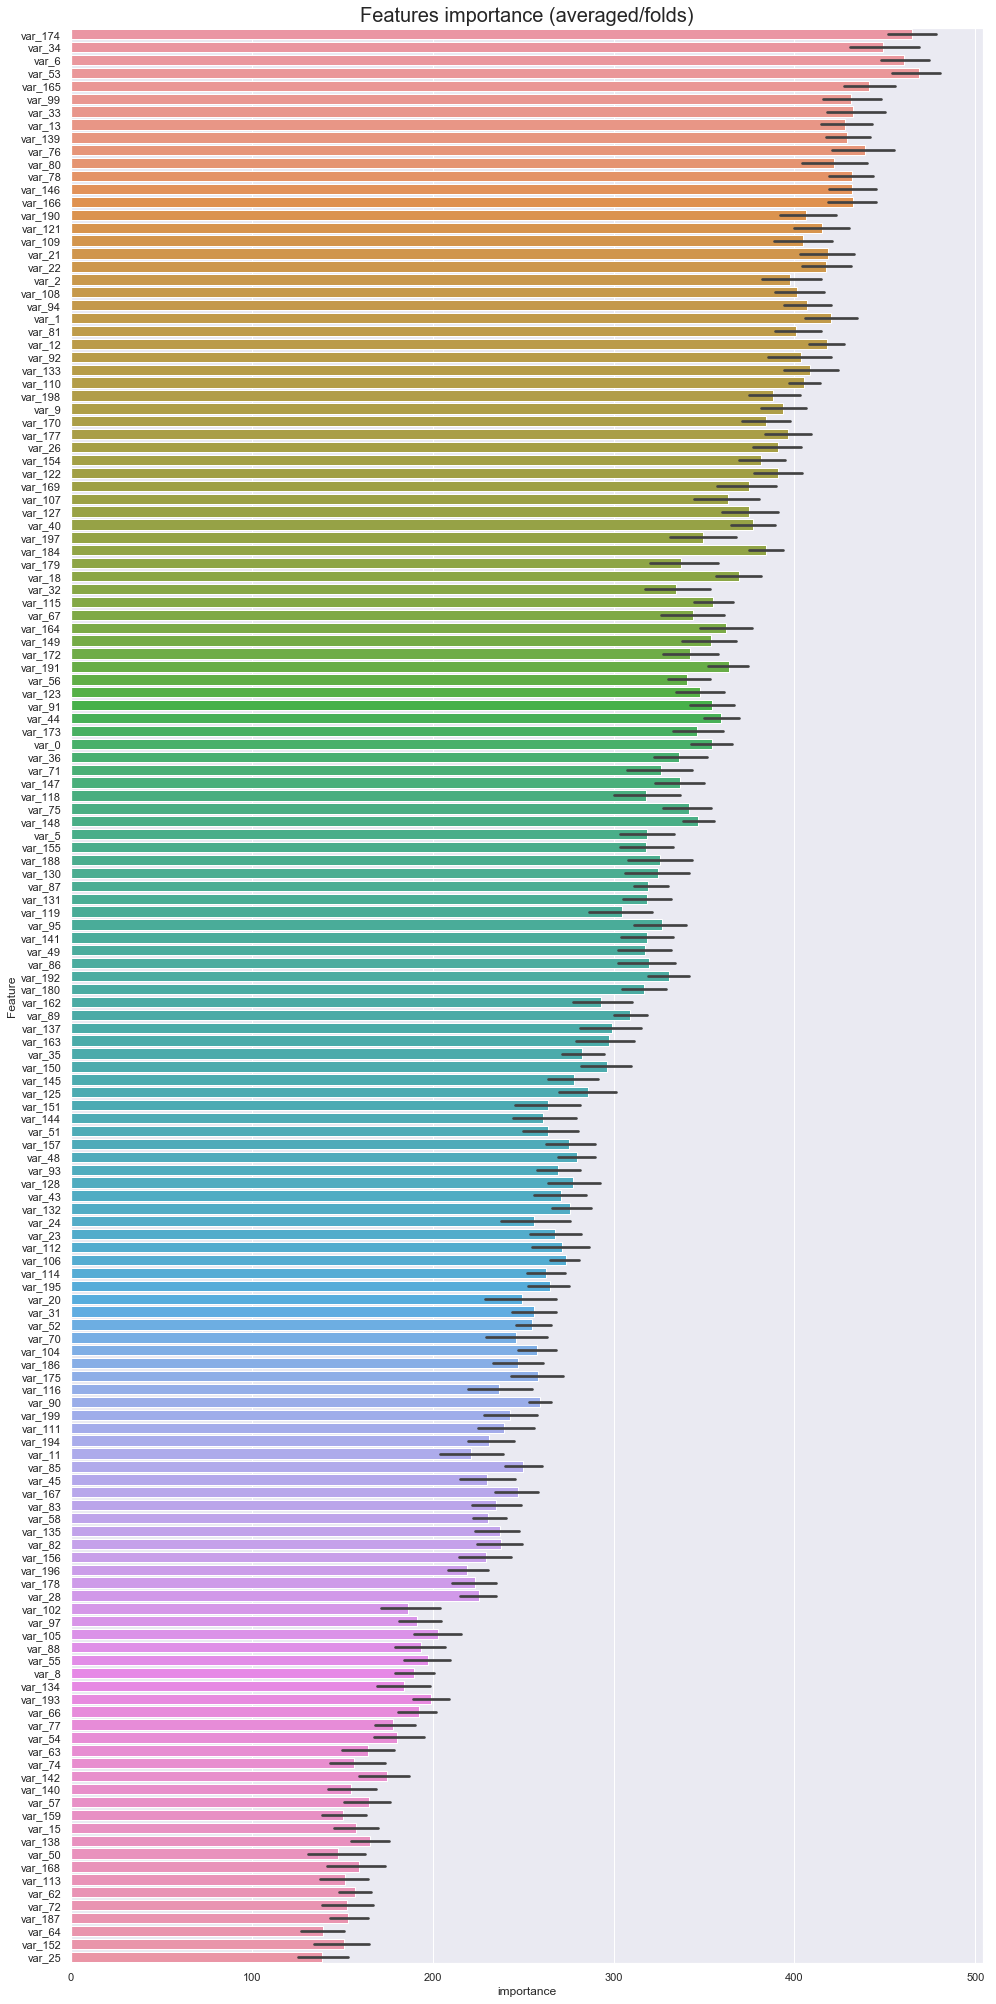

In [80]:
sns.set(font_scale=1)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)', fontsize=20)
plt.tight_layout()
plt.savefig('FI.png')

# Submit Data:

In [81]:
submission_df = pd.DataFrame({"ID_code":test_data["ID_code"].values})
submission_df["target"] = predictions
submission_df.to_csv("submission.csv", index=False)

<hr>

# References

- https://www.kaggle.com/ruby33421/quick-start-0-9-lgb-with-new-features
- https://www.youtube.com/watch?v=TIgfjmp-4BA
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
